# Import Libraries

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import glob
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, LogLocator
from matplotlib.ticker import FuncFormatter, LogLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter, LogFormatter
from scipy.stats import zscore
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import pytz
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import io
import os
from pptx import Presentation
from matplotlib.patches import Patch
from pptx.util import Inches
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from functools import reduce

# Set Plotting Parameters

Fontsize, linewidth, etc. Feel free to change these as you wish

In [2]:
np.set_printoptions(precision = 4)

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = '1.5'
mpl.rcParams['ytick.major.width'] = '1.5'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.minor.width'] = '1.0'
mpl.rcParams['xtick.major.size'] = '10.0'
mpl.rcParams['ytick.major.size'] = '10.0'
mpl.rcParams['xtick.minor.size'] = '5.0'
mpl.rcParams['ytick.minor.size'] = '5.0'
mpl.rcParams['axes.linewidth'] = '1.5'
mpl.rcParams['axes.labelsize'] = '20'
mpl.rcParams['axes.titlesize'] = '20' 
mpl.rcParams['figure.titlesize'] = '20'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'
mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

# Define paths

In [3]:
# Path to SMPS data file (the cleaned_csv saved at the end of code in cleaning_smps_csv_VIB.ipynb)
pathp = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/smps_full_dataset_2023-08-04_to_2025-08-25.csv'

# # Path to folder in which you keep your Aethelometer csv files
# aeth_path = '/Users/vineblankenship/Research/ASCENT/AETHDataSummer2025'
#
# # Path to individual Aethelometer csv files for the concatenation step
# aeth_csv_files = glob.glob(aeth_path  + '/*.csv')

# output_folder is the destination folder of all of the plots below
output_folder = 'C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output'


# Define the dataframe as dfp (short for DataFrame Pico Rivera, in this case)

Load in the csv from the SMPS path defined above and define a time series dataframe for which the local_time column is the index

In [4]:
dfp = pd.read_csv(pathp)

In [5]:
tsdfp = dfp.set_index('local_time')
tsdfp = tsdfp.sort_index()

## Import Puru's flagged data

In [18]:
df_flagged = pd.read_csv(r'C:\Users\GeorgiaRg\Documents\ASCENT\SMPS\Cleaned from Puru\valid_auto_qc_SMPS.csv', dtype={'flag': float, 'comment': str, 'Comments': str, 'manual_qc_flag': float})
tsdf_flagged = df_flagged.set_index('sample_datetime_utc')
tsdf_flagged = tsdf_flagged.sort_index()

## Paths for AQMD data

In [22]:
# Define specific paths for each parameter
# Units: Temp (F), WD (degrees), WS (mph), NO2 (ppb), CO (ppm), O3 (ppb)
path_dict = {
    'Temp': r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\Temperature',
    'WD':   r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\WD',
    'WS':   r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\WS',
    'NO2':  r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\NO2',
    'CO':   r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\CO',
    'O3':   r'C:\Users\GeorgiaRg\Documents\ASCENT\AQMD_Data\O3'
}

data_frames = []

# Loop through each parameter
for param_name, folder_path in path_dict.items():
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    if not csv_files:
        print(f"Warning: No CSV files found for {param_name} in {folder_path}")
        continue

    # Read and combine all CSVs for this specific parameter
    df_temp = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

    # Check if required columns exist
    if 'Date Time' in df_temp.columns and 'Value' in df_temp.columns:
        # Convert time column
        df_temp['Date Time'] = pd.to_datetime(df_temp['Date Time'])

        # --- FILTER STEP ---
        # Keep ONLY 'Date Time' and 'Value'
        df_temp = df_temp[['Date Time', 'Value']]

        # --- RENAME STEP ---
        # Rename 'Value' to e.g., 'Temp_Value', 'WS_Value' to avoid conflicts
        df_temp = df_temp.rename(columns={'Value': f'{param_name}'})

        # Sort and remove duplicate timestamps
        df_temp = df_temp.sort_values('Date Time').drop_duplicates(subset=['Date Time'])

        data_frames.append(df_temp)
    else:
        print(f"Error: Missing 'Date Time' or 'Value' column in {param_name} files.")

# 3. Merge all DataFrames into one

if data_frames:
    # Merge all dataframes on 'Date Time' using an outer join
    df_met_data = reduce(lambda left, right: pd.merge(left, right, on='Date Time', how='outer'), data_frames)

    # Sort final dataframe by time
    df_met_data = df_met_data.sort_values('Date Time').reset_index(drop=True)

    # --- Convert Fahrenheit to Celsius and add new column---
    if 'Temp' in df_met_data.columns:
        # Create a new column 'Temp_C'
        df_met_data['Temp_C'] = (df_met_data['Temp'] - 32) * 5/9

        # Optional: Round to 2 decimal places for cleaner data
        df_met_data['Temp_C'] = df_met_data['Temp_C'].round(2)

    # Verify the import
    print("Final Combined Data Shape:", df_met_data.shape)
    print("Columns:", df_met_data.columns.tolist())
    print(df_met_data.head()) # Preview
else:
    print("No data was imported.")

C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3783777290.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp['Date Time'] = pd.to_datetime(df_temp['Date Time'])
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3783777290.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp['Date Time'] = pd.to_datetime(df_temp['Date Time'])
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3783777290.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_temp['Date Time'] = pd.to_datetime(df_temp['Date Time'])
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykerne

Final Combined Data Shape: (21736, 8)
Columns: ['Date Time', 'Temp', 'WD', 'WS', 'NO2', 'CO', 'O3', 'Temp_C']
            Date Time  Temp     WD   WS   NO2   CO    O3  Temp_C
0 2023-08-01 00:00:00  73.0   55.0  1.0   9.0  0.0  14.0   22.78
1 2023-08-01 01:00:00  73.0  164.0  2.0  17.0  0.0   9.0   22.78
2 2023-08-01 02:00:00  73.0   80.0  0.0  17.0  0.0   6.0   22.78
3 2023-08-01 03:00:00  72.0   68.0  0.0  25.0  0.0   1.0   22.22
4 2023-08-01 04:00:00  72.0  140.0  1.0  24.0  0.0   0.0   22.22


# Locate Relevant Concentration Columns (This varies site to site and it is different for Shiny csv files versus csv files downloaded locally at sites)

In [6]:
tsdfp.columns[41:156] # your column range here

Index(['13.1', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.8', '661.17', '685.39', '710.5',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define the concentration_columns range as the range you have selected above

In [7]:
concentration_columns = slice(41, 156) # your column range here

# Calculations from original ASCENT SMPS code: 

Calculating dN/dlogDp at standard temperature and pressure (STP) 

In [8]:
# read diameter as array
mid_Dp = np.array([float(x) for x in tsdfp.columns[concentration_columns]]) # pico
avg_diffp = np.mean(np.diff(np.log10(mid_Dp)))

D_boundp = np.full(mid_Dp.shape[0]+1, np.nan)
for i in range (1, (len(D_boundp)-1)):
    D_boundp[i] = 10 ** (0.5 * (np.log10(mid_Dp[i])+np.log10(mid_Dp[i-1])))
    
D_boundp[0] = 10 ** (np.log10(mid_Dp[0]) - 0.5*avg_diffp)
D_boundp[-1] = 10 ** (np.log10(mid_Dp[-1]) + 0.5*avg_diffp)
D_lowp = D_boundp[0:-1]
D_highp = D_boundp[1:]
dlogDpp = np.log10(D_highp) - np.log10(D_lowp)

## Clean up of bad data_added by GA

In [9]:
# 1. Select only the diameter columns using the slice defined in Cell 9
data_cols = tsdfp.iloc[:, concentration_columns]

# 2. Identify rows where the number of unique values across these columns is 1
# (This catches rows where every bin has the same number, e.g., all 0s or all -999s)
bad_rows_mask = data_cols.nunique(axis=1) == 1

# 3. Filter the dataframe to keep only the rows that are NOT 'bad'
tsdfp_cleaned = tsdfp[~bad_rows_mask].copy()

# 4. Print removal statistics for verification
n_removed = bad_rows_mask.sum()
print(f"Rows removed: {n_removed}")
print(f"Original shape: {tsdfp.shape}")
print(f"Cleaned shape:  {tsdfp_cleaned.shape}")

# 5. Overwrite the main dataframe with the cleaned version for subsequent steps
tsdfp = tsdfp_cleaned

Rows removed: 592
Original shape: (431271, 413)
Cleaned shape:  (430679, 413)


In [10]:
# STP conversion factor
STP_factorp = (101.35/tsdfp['Sheath Pressure (kPa)']) * ((273.15+tsdfp['Sheath Temp (C)'])/273.15)

In [11]:
# Check the column indices to ensure you run the calculations on the concentrations 
tsdfp.columns[concentration_columns]

Index(['13.1', '13.58', '14.07', '14.59', '15.12', '15.68', '16.25', '16.85',
       '17.47', '18.11',
       ...
       '572.55', '593.52', '615.27', '637.8', '661.17', '685.39', '710.5',
       '736.53', '763.51', '791.48'],
      dtype='str', length=115)

## Define dNdlogDp_stpp, dVdlogDp_stpp, dMdlogDp_stpp, N_stp, V_stp, M_stp

In [12]:
# calculate total number of each scan 
artsdfp = np.array(tsdfp)

dNdlogDpp = artsdfp[:, concentration_columns] # pico

dNdlogDp_stpp = dNdlogDpp * np.array(STP_factorp)[:,None]

dN_stpp = dNdlogDp_stpp * dlogDpp

N_stp = np.nansum(dN_stpp, axis=1)

# # calculate volume distribution and total volume of each scan 
dVdlogDp_stpp = (np.pi/6.) * (mid_Dp/1e3) **3 * dNdlogDp_stpp  #um3/cm3

dV_stpp = dVdlogDp_stpp * dlogDpp

V_stp = np.nansum(dV_stpp, axis=1)         #um3/cm3

# calculate mass distribution and total mass of each scan by assuming a particle density
density = 1.0      #  g/cm³
dMdlogDp_stpp = (density/1e9) * (np.pi/6.) * mid_Dp**3 * dNdlogDp_stpp    #ug/m3

dM_stp = dMdlogDp_stpp * dlogDpp

M_stp = np.nansum(dM_stp, axis=1)         #ug/m3

print(dM_stp.shape)

(430679, 115)


## Monthly average dNdlogDp and dMdlogDp (exported images in a powerpoint)

In [13]:
# 1. Initialize the PowerPoint Presentation
prs = Presentation()

# 2. Prepare the data
# Ensure the index is datetime
if not isinstance(tsdfp.index, pd.DatetimeIndex):
    tsdfp.index = pd.to_datetime(tsdfp.index)

# Create temporary DataFrames for easier grouping
# We assume dNdlogDp_stpp and dMdlogDp_stpp align with tsdfp rows
df_dN = pd.DataFrame(dNdlogDp_stpp, index=tsdfp.index)
df_dM = pd.DataFrame(dMdlogDp_stpp, index=tsdfp.index)

# 3. Group by Month
# We use the index of one of them to define the groups
monthly_groups = df_dN.groupby(df_dN.index.to_period('M'))

print(f"Generating monthly distribution slides for {len(monthly_groups)} months...")

# 4. Loop through each month
for period, group_dN in monthly_groups:
    month_name = period.strftime('%B %Y')

    # Get the corresponding dM data for this month using the index
    group_dM = df_dM.loc[group_dN.index]

    # Calculate the mean across time (axis 0) for this month
    # This results in a 1D array of average distribution for the month
    avg_dN = group_dN.mean(axis=0).values
    avg_dM = group_dM.mean(axis=0).values

    # --- Create Figure with 2 Subplots (Top: dN, Bottom: dM) ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # ==========================================
    # PLOT 1: Average dN/dlogDp (Top)
    # ==========================================
    # mid_Dp is the diameter array from Cell 8
    ax1.plot(mid_Dp, avg_dN, color='tab:blue', linewidth=2)
    ax1.set_xscale('log')
    ax1.set_ylabel('dN/dlogDp (#/cm³)', fontsize=12)
    ax1.set_title(f'{month_name}: Average Number Size Distribution', fontsize=14)
    ax1.grid(True, which="both", linestyle='--', alpha=0.6)

    # ==========================================
    # PLOT 2: Average dM/dlogDp (Bottom)
    # ==========================================
    ax2.plot(mid_Dp, avg_dM, color='tab:red', linewidth=2)
    ax2.set_xscale('log')
    ax2.set_xlabel('Particle Diameter (nm)', fontsize=12)
    ax2.set_ylabel('dM/dlogDp (µg/m³)', fontsize=12)
    ax2.set_title(f'{month_name}: Average Mass Size Distribution', fontsize=14)
    ax2.grid(True, which="both", linestyle='--', alpha=0.6)

    plt.tight_layout()

    # --- Save Figure to Memory Buffer ---
    image_stream = io.BytesIO()
    plt.savefig(image_stream, format='png', dpi=150)
    image_stream.seek(0)
    plt.close(fig)

    # --- Add Slide to PowerPoint ---
    slide_layout = prs.slide_layouts[6] # Blank slide
    slide = prs.slides.add_slide(slide_layout)

    # Add a title text box for clarity (Optional)
    # txBox = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5))
    # txBox.text_frame.text = f"Distributions: {month_name}"

    # Center image on slide
    pic_height = Inches(7.0)
    left = Inches(1.5)
    top = Inches(0.25)

    slide.shapes.add_picture(image_stream, left, top, height=pic_height)

# 5. Save the Presentation
output_filename = 'Monthly_Size_Distributions_dN_dM.pptx'
output_pptx = os.path.join(output_folder, output_filename)
prs.save(output_pptx)

print(f"Presentation saved successfully to: {output_pptx}")

Generating monthly distribution slides for 25 months...
Presentation saved successfully to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Monthly_Size_Distributions_dN_dM.pptx


## Export dM and dMdlogDp to csv files

In [ ]:
# 1. Create a DataFrame for the mass distribution data
# We use the time index from tsdfp and the diameters (mid_Dp) as column headers
df_dM_stp = pd.DataFrame(dM_stp, index=tsdfp.index, columns=mid_Dp)
df_dMdlogDp = pd.DataFrame(dMdlogDp_stpp, index=tsdfp.index, columns=mid_Dp)

# 2. Construct the full output filename
# This uses the 'output_folder' variable defined earlier in your notebook
output_filename = os.path.join(output_folder, 'dMdlogDp_stpp_export.csv')
output_filename_dM = os.path.join(output_folder, 'dM_stp_export.csv')

# 3. Export to CSV
df_dMdlogDp.to_csv(output_filename)
df_dM_stp.to_csv(output_filename_dM)

## PM0.1 and PM1 calculations

In [14]:
# We convert the index to datetime to ensure resampling works, using 'coerce' to handle any bad timestamp strings
# tsdfp is from Cell 5
timestamps = pd.to_datetime(tsdfp.index, errors='coerce')
df_sums = pd.DataFrame(index=timestamps)

# Identify indices where the diameter (mid_Dp) is less than 105
# mid_Dp is the array of diameters corresponding to the columns of dM_stp
indices_lt_105 = np.where(mid_Dp < 105)[0]

# Identify indices where the diameter (mid_Dp) is greater than 50 nm for N50
indices_gt_50 = np.where(mid_Dp > 50)[0]

# Calculate the row-wise sums
# Sum of columns where Dp < 105 nm, meaning PM0.1 calculation (ultrafine particles, pm_f)
pm_upf = np.nansum(dM_stp[:, indices_lt_105], axis=1)

# Sum of all columns, meaning PM1 calculation (fine particles, pm_f)
pm_f = np.nansum(dM_stp, axis=1)

# Calculate N50: Sum of columns where Dp > 50 nm using dN (dN_stpp)
n50_val = np.nansum(dN_stpp[:, indices_gt_50], axis=1)

# Create a DataFrame with the results
# We use the index from tsdfp to ensure the timestamps align correctly
df_sums['PM0.1'] = pm_upf
df_sums['PM1'] = pm_f
df_sums['N10'] = N_stp
df_sums['N50'] = n50_val

# --- CLEANING STEPS ---

# 1. Replace 0 with NaN
# This prevents periods with missing data (which sum to 0) from skewing averages
df_sums = df_sums.replace(0, np.nan)

# 2. Filter out rows where PM1 > 150 (likely outliers/bad data)
# We set the entire row to NaN so these scans are not included in the hourly average
df_sums.loc[df_sums['PM1'] > 150, :] = np.nan

# ----------------------

# Resample to Hourly Averages
# 'H' stands for hourly frequency. We use mean() to get the average concentration per hour.
df_hourly = df_sums.resample('1h').mean()

# Drop any empty hours (optional, keeps plot clean)
df_hourly = df_hourly.dropna()

# Export to CSV
output_filename_hourly = os.path.join(output_folder, 'hourly_averages.csv')
df_hourly.to_csv(output_filename_hourly)

print(df_hourly)

                        PM0.1        PM1           N10           N50
local_time                                                          
2023-08-04 13:00:00  1.583585  10.520073  15304.529580   8707.782992
2023-08-04 14:00:00  2.093302  10.769883  24848.360530  10811.473108
2023-08-04 15:00:00  1.690785  10.101016  24815.642506   8401.474394
2023-08-04 16:00:00  1.359770   9.190854  24120.393038   6575.340251
2023-08-04 17:00:00  1.123317   8.155879  22745.957316   5474.918445
...                       ...        ...           ...           ...
2025-08-25 10:00:00  0.671009  10.656133  10408.617425   4138.685998
2025-08-25 11:00:00  0.814865  10.660779  11684.033143   4895.570909
2025-08-25 12:00:00  1.047397  11.726390  14474.423216   6022.677042
2025-08-25 13:00:00  1.542287  11.902966  18965.149888   8853.831363
2025-08-25 14:00:00  2.784114  13.145464  29054.888292  14863.092960

[9638 rows x 4 columns]


## Plot hourly PM0.1 vs PM1 for the whole data file

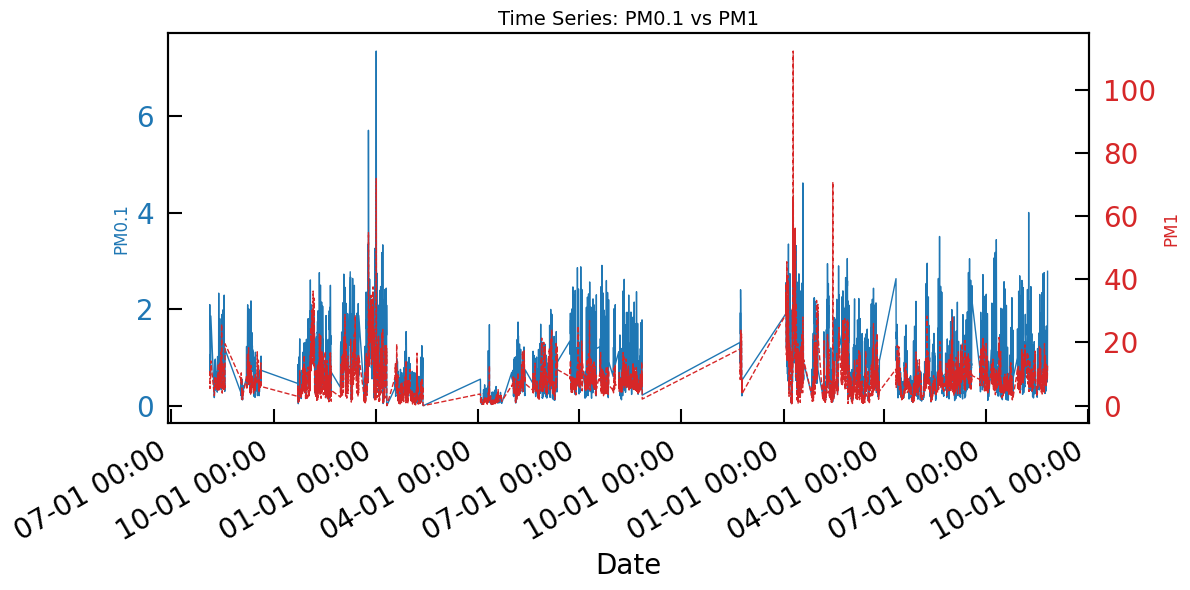

In [15]:
# 1. Create the figure and primary axis (left)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'PM0.1' on the left axis (Blue)
color_left = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('PM0.1', color=color_left, fontsize=12)
ax1.plot(df_hourly.index, df_hourly['PM0.1'], color=color_left, linewidth=1, label='PM0.1')
ax1.tick_params(axis='y', labelcolor=color_left)

# 2. Create the secondary axis (right) that shares the x-axis
ax2 = ax1.twinx()

# Plot 'PM1' on the right axis (Red)
color_right = 'tab:red'
ax2.set_ylabel('PM1', color=color_right, fontsize=12)
ax2.plot(df_hourly.index, df_hourly['PM1'], color=color_right, linewidth=1, linestyle='--', label='PM1')
ax2.tick_params(axis='y', labelcolor=color_right)

# 3. Formatting the Date Axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate() # Rotation

# 4. Title and Layout
plt.title('Time Series: PM0.1 vs PM1', fontsize=14)
fig.tight_layout()
plt.show()

## Plot hourly PM0.1 vs PM1 and N10 monthly timeseries and scatterplot and export the graphs in a powerpoint

In [15]:
# =========================================================
# POWERPOINT GENERATION
# =========================================================

# 1. Check if df_hourly exists (from Cell 26)
if 'df_hourly' not in locals():
    raise ValueError("variable 'df_hourly' not found. Please run the 'PM0.1 and PM1 calculations' cell (Cell 26) first.")

# 2. Initialize Presentation
prs = Presentation()

# 3. Group data by Month
# Ensure index is datetime for grouping
if not isinstance(df_hourly.index, pd.DatetimeIndex):
    df_hourly.index = pd.to_datetime(df_hourly.index)

monthly_groups = df_hourly.groupby(df_hourly.index.to_period('M'))

# 4. Helper Function for 3-Panel Slide
def create_three_panel_slide(prs, df_data, month_name, col_y1, col_y2, y1_label, y2_label, y2_color):
    """
    Creates a slide with:
    - Top: Time Series (spanning width) with VISIBLE timestamps
    - Bottom Left: Scatter Plot
    - Bottom Right: Diurnal Plot
    """

    # --- 1. Statistics ---
    valid_data = df_data[[col_y1, col_y2]].dropna()
    if len(valid_data) > 1:
        corr = valid_data[col_y1].corr(valid_data[col_y2])
        r_squared = corr ** 2
    else:
        r_squared = 0.0

    # Diurnal average (group by hour)
    diurnal_df = df_data.groupby(df_data.index.hour)[[col_y1, col_y2]].mean()

    # --- 2. Figure Setup ---
    fig = plt.figure(figsize=(13, 10))
    # Adjust layout to make room for x-axis labels
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], hspace=0.4, wspace=0.25)

    # --- PLOT 1: Time Series (TOP) ---
    ax1 = fig.add_subplot(gs[0, :])

    color_left = 'tab:blue'
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel(y1_label, color=color_left, fontsize=12)
    ax1.plot(df_data.index, df_data[col_y1], color=color_left, linewidth=1, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color_left)

    ax2 = ax1.twinx()
    ax2.set_ylabel(y2_label, color=y2_color, fontsize=12)
    ax2.plot(df_data.index, df_data[col_y2], color=y2_color, linewidth=1, linestyle='--', label=y2_label)
    ax2.tick_params(axis='y', labelcolor=y2_color)

    # --- X-AXIS FORMATTING (Timestamps) ---
    # Set tick every 3 days to ensure visibility without overcrowding
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    # Format as Month-Day (e.g., 01-15)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    # Rotate labels 45 degrees
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    # Force label visibility
    ax1.tick_params(axis='x', which='major', labelbottom=True)

    ax1.set_title(f'Time Series: {month_name} ({y1_label} vs {y2_label})', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- PLOT 2: Scatter Plot (BOTTOM LEFT) ---
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.scatter(df_data[col_y1], df_data[col_y2], alpha=0.6, color='purple', edgecolors='w', s=40)
    ax3.set_xlabel(f'{y1_label}')
    ax3.set_ylabel(f'{y2_label}')
    ax3.set_title(f'Correlation ($R^2 = {r_squared:.3f}$)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.6)

    # --- PLOT 3: Diurnal Plot (BOTTOM RIGHT) ---
    ax4 = fig.add_subplot(gs[1, 1])

    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel(y1_label, color=color_left, fontsize=12)
    ax4.plot(diurnal_df.index, diurnal_df[col_y1], color=color_left, linewidth=2, marker='o', markersize=4)
    ax4.tick_params(axis='y', labelcolor=color_left)

    ax5 = ax4.twinx()
    ax5.set_ylabel(y2_label, color=y2_color, fontsize=12)
    ax5.plot(diurnal_df.index, diurnal_df[col_y2], color=y2_color, linewidth=2, linestyle='--', marker='s', markersize=4)
    ax5.tick_params(axis='y', labelcolor=y2_color)

    ax4.set_xticks(range(0, 24, 4))
    ax4.set_xlim(0, 23)
    ax4.set_title(f'Diurnal Profile', fontsize=12)
    ax4.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()

    # --- Save to Slide ---
    image_stream = io.BytesIO()
    plt.savefig(image_stream, format='png', dpi=150)
    image_stream.seek(0)
    plt.close(fig)

    slide_layout = prs.slide_layouts[6] # Blank slide
    slide = prs.slides.add_slide(slide_layout)

    pic_height = Inches(7.0)
    # Center on 10-inch slide (approx width 9.1 inches)
    left = Inches(0.45)
    top = Inches(0.25)

    slide.shapes.add_picture(image_stream, left, top, height=pic_height)


# 5. Main Loop to Generate Slides
print(f"Generating 3-slide sets for {len(monthly_groups)} months using CLEANED df_hourly...")

for period, df_month in monthly_groups:
    month_name = period.strftime('%B %Y')

    # Slide 1: PM0.1 vs PM1 (Red)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'PM1', 'PM0.1', 'PM1', 'tab:red'
    )

    # Slide 2: PM0.1 vs N10 (Black)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'N10', 'PM0.1', 'N10', 'black'
    )

    # Slide 3: PM0.1 vs N50 (Purple)
    create_three_panel_slide(
        prs, df_month, month_name,
        'PM0.1', 'N50', 'PM0.1', 'N50', 'tab:purple'
    )

# 6. Save the Presentation
output_pptx = os.path.join(output_folder, 'Monthly_Analysis_PM_N10_N50.pptx')
prs.save(output_pptx)
print(f"Presentation saved successfully to: {output_pptx}")

Generating 3-slide sets for 21 months using CLEANED df_hourly...


C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32848\1334504075.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32848\1334504075.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32848\1334504075.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32848\1334504075.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_32848\1334504075.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be in

Presentation saved successfully to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Monthly_Analysis_PM_N10_N50.pptx


## Seasonal Boxplots of PM0.1, PM1, N10 and correlations

DATA AVAILABILITY PER SEASON
Autumn    : 4 months of data
Winter    : 5 months of data
Spring    : 5 months of data
Summer    : 7 months of data



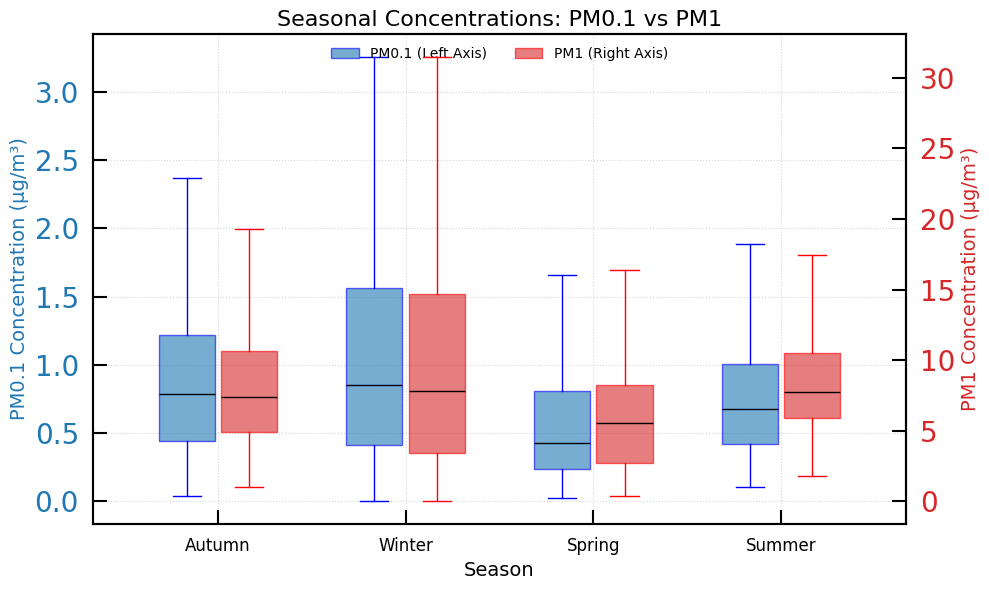

Boxplot 1 saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Boxplot_Seasonal_Dual_Axis.png


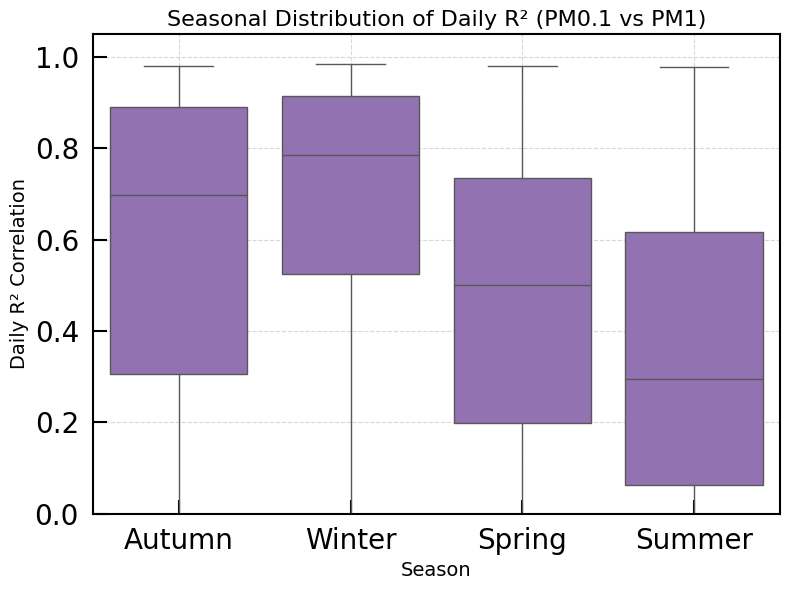

Boxplot 2 saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Boxplot_Seasonal_R2_PM01_PM1.png


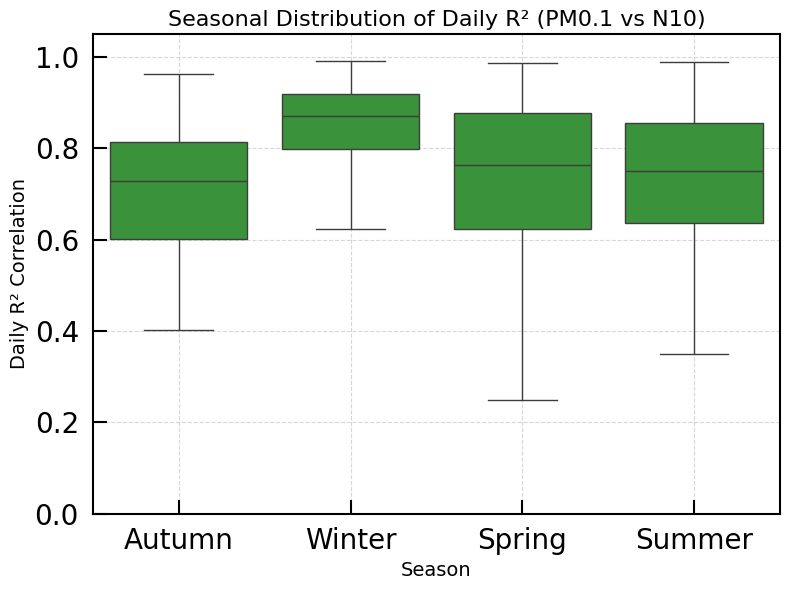

Boxplot 3 saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Boxplot_Seasonal_R2_PM01_N10.png


In [29]:
# 1. Prepare Data & Define Seasons
# ---------------------------------------------------------
# Ensure df_hourly exists (from Cell 26) and index is datetime
df_seasonal = df_hourly.copy()
if not isinstance(df_seasonal.index, pd.DatetimeIndex):
    df_seasonal.index = pd.to_datetime(df_seasonal.index)

# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_seasonal['Season'] = df_seasonal.index.month.map(get_season)
season_order = ['Autumn', 'Winter', 'Spring', 'Summer']

# --- Print Month Counts ---
print("="*40)
print("DATA AVAILABILITY PER SEASON")
print("="*40)
for season in season_order:
    # Filter data for the season
    season_data = df_seasonal[df_seasonal['Season'] == season]

    # Count unique Year-Month combinations (e.g., Jan 2023 and Jan 2024 count as 2)
    num_months = season_data.index.to_period('M').nunique()

    # Optional: Get specific month names for verification
    # month_names = season_data.index.strftime('%b-%Y').unique().tolist()

    print(f"{season:<10}: {num_months} months of data")
print("="*40 + "\n")

# =========================================================
# BOXPLOT 1: Concentrations with Dual Axes (PM0.1 Left, PM1 Right)
# =========================================================

# Prepare lists of data for plotting
data_pm01 = [df_seasonal[df_seasonal['Season'] == s]['PM0.1'].dropna() for s in season_order]
data_pm1 = [df_seasonal[df_seasonal['Season'] == s]['PM1'].dropna() for s in season_order]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create secondary y-axis sharing the same x-axis

# Define positions
indices = np.arange(len(season_order))
width = 0.3  # Width of the boxes

# Plot PM0.1 on Left Axis (Shifted Left)
bp1 = ax1.boxplot(
    data_pm01,
    positions=indices - width/1.8,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor='tab:blue', color='blue', alpha=0.6),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    showfliers=False
)

# Plot PM1 on Right Axis (Shifted Right)
bp2 = ax2.boxplot(
    data_pm1,
    positions=indices + width/1.8,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor='tab:red', color='red', alpha=0.6),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='red'),
    capprops=dict(color='red'),
    showfliers=False
)

# Formatting Axes
ax1.set_ylabel('PM0.1 Concentration (µg/m³)', color='tab:blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2.set_ylabel('PM1 Concentration (µg/m³)', color='tab:red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_xticks(indices)
ax1.set_xticklabels(season_order, fontsize=12)
ax1.set_xlabel('Season', fontsize=14)
ax1.set_title('Seasonal Concentrations: PM0.1 vs PM1', fontsize=16)

# Custom Legend
legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='blue', alpha=0.6, label='PM0.1 (Left Axis)'),
    Patch(facecolor='tab:red', edgecolor='red', alpha=0.6, label='PM1 (Right Axis)')
]
ax1.legend(handles=legend_elements, loc='upper center', frameon=False, ncol=2)

ax1.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()

# Save Plot 1
plot1_filename = os.path.join(output_folder, 'Boxplot_Seasonal_Dual_Axis.png')
plt.savefig(plot1_filename, dpi=300)
plt.show()
print(f"Boxplot 1 saved to: {plot1_filename}")


# =========================================================
# CALCULATE DAILY CORRELATIONS (R²)
# =========================================================
daily_r2_list = []

for date, day_group in df_seasonal.groupby(df_seasonal.index.date):
    # Need sufficient data points (e.g., > 12 hours)
    if len(day_group) > 12:
        # 1. R2 for PM0.1 vs PM1
        data_pm = day_group[['PM0.1', 'PM1']].dropna()
        if len(data_pm) > 12:
            r_pm = data_pm['PM0.1'].corr(data_pm['PM1'])
            r2_pm = r_pm**2
        else:
            r2_pm = np.nan

        # 2. R2 for PM0.1 vs N10
        data_n10 = day_group[['PM0.1', 'N10']].dropna()
        if len(data_n10) > 12:
            r_n10 = data_n10['PM0.1'].corr(data_n10['N10'])
            r2_n10 = r_n10**2
        else:
            r2_n10 = np.nan

        # Store results
        month = pd.to_datetime(date).month
        season = get_season(month)

        daily_r2_list.append({
            'Date': date,
            'Season': season,
            'R2_PM_PM': r2_pm,
            'R2_PM_N10': r2_n10
        })

df_r2 = pd.DataFrame(daily_r2_list)

# =========================================================
# BOXPLOT 2: R² Correlation (PM0.1 vs PM1)
# =========================================================
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_r2,
    x='Season',
    y='R2_PM_PM',
    order=season_order,
    color='tab:purple',
    showfliers=False
)

plt.title('Seasonal Distribution of Daily R² (PM0.1 vs PM1)', fontsize=16)
plt.ylabel('Daily R² Correlation', fontsize=14)
plt.xlabel('Season', fontsize=14)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save Plot 2
plot2_filename = os.path.join(output_folder, 'Boxplot_Seasonal_R2_PM01_PM1.png')
plt.savefig(plot2_filename, dpi=300)
plt.show()
print(f"Boxplot 2 saved to: {plot2_filename}")


# =========================================================
# BOXPLOT 3: R² Correlation (PM0.1 vs N10)
# =========================================================
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_r2,
    x='Season',
    y='R2_PM_N10',
    order=season_order,
    color='tab:green',
    showfliers=False
)

plt.title('Seasonal Distribution of Daily R² (PM0.1 vs N10)', fontsize=16)
plt.ylabel('Daily R² Correlation', fontsize=14)
plt.xlabel('Season', fontsize=14)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save Plot 3
plot3_filename = os.path.join(output_folder, 'Boxplot_Seasonal_R2_PM01_N10.png')
plt.savefig(plot3_filename, dpi=300)
plt.show()
print(f"Boxplot 3 saved to: {plot3_filename}")

## Seasonal Boxplots of AQMD data (Temp, NO2, O3)

Plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_Boxplots_Met_Gases.png


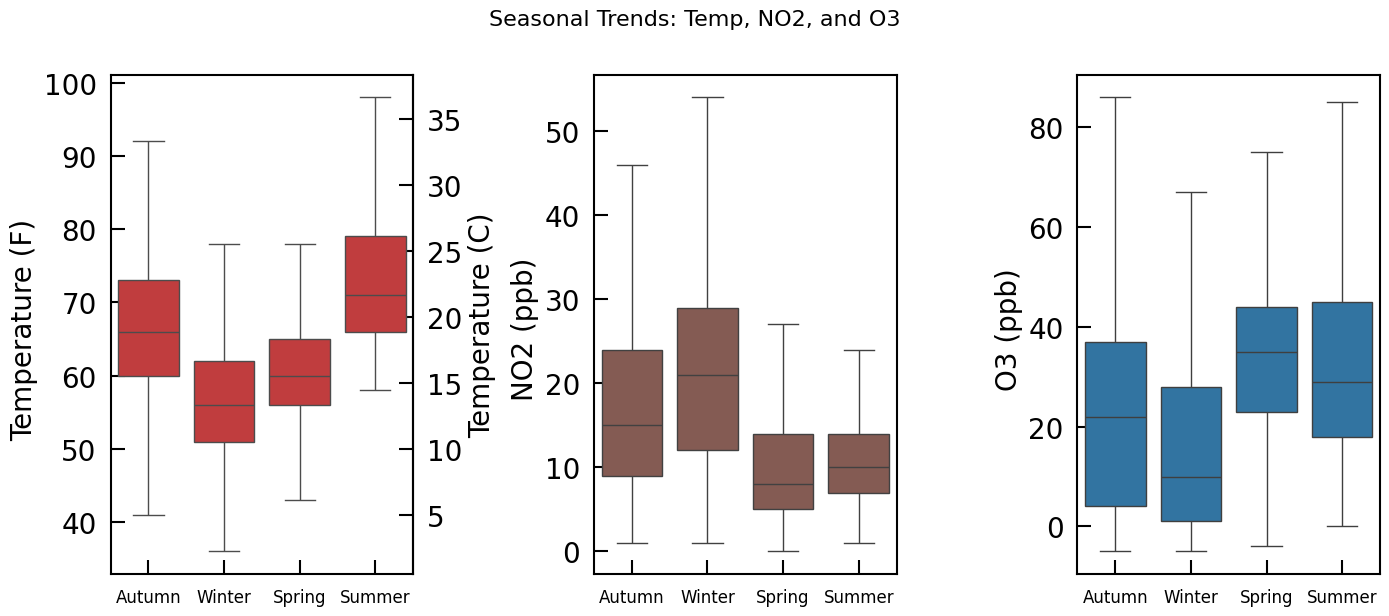


 DATA COVERAGE (Months per Season)
Autumn    : 9 months
Winter    : 8 months
Spring    : 6 months
Summer    : 7 months



In [23]:
# 1. Prepare the Data
# Ensure df_met_data exists (from your import step)
if 'df_met_data' not in locals():
    print("Error: 'df_met_data' not found. Please run the data import cell first.")
else:
    # Create a working copy
    df_met_plot = df_met_data.copy()

    # Ensure Date Time is datetime
    if not pd.api.types.is_datetime64_any_dtype(df_met_plot['Date Time']):
        df_met_plot['Date Time'] = pd.to_datetime(df_met_plot['Date Time'])

    # Set index for easy time manipulation
    df_met_plot = df_met_plot.set_index('Date Time')

    # Define Seasons
    def get_season_local(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'

    df_met_plot['Season'] = df_met_plot.index.month.map(get_season_local)
    season_order = ['Autumn', 'Winter', 'Spring', 'Summer']

    # Setup the 1x3 Plotting Grid
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    axes = axes.flatten()

    # Define the parameters to plot (Column Name, Label, Color)
    plot_params = [
        ('Temp', 'Temperature (F)', 'tab:red'),
        ('NO2',  'NO2 (ppb)',         'tab:brown'),
        ('O3',   'O3 (ppb)',          'tab:blue')
    ]

    # Generate Boxplots
    for i, (col, label, color) in enumerate(plot_params):
        ax = axes[i]

        # Check if column exists before plotting
        if col in df_met_plot.columns:
            sns.boxplot(
                data=df_met_plot,
                x='Season',
                y=col,
                order=season_order,
                ax=ax,
                color=color,
                showfliers=False
            )
            ax.set_ylabel(f'{label} ')
            ax.set_xlabel('')
            ax.tick_params(axis='x', labelsize=12)

            # --- ADD CELSIUS AXIS ---
            if col == 'Temp':
                # Define conversion functions
                def f_to_c(x): return (x - 32) * 5 / 9
                def c_to_f(x): return (x * 9 / 5) + 32

                # Create secondary axis on the right
                secax = ax.secondary_yaxis('right', functions=(f_to_c, c_to_f))
                secax.set_ylabel('Temperature (C)')
            # ----------------------------------

        else:
            ax.text(0.5, 0.5, f'Column {col} not found', ha='center', va='center')

    plt.suptitle('Seasonal Trends: Temp, NO2, and O3', fontsize=16, y=1.02)
    plt.tight_layout()

    # 4. Save the Figure
    # Make sure 'output_folder' is defined, otherwise replace with a string path like r'C:\Users\...'
    if 'output_folder' in locals():
        output_filename = os.path.join(output_folder, 'Seasonal_Boxplots_Met_Gases.png')
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {output_filename}")

    plt.show()

# =========================================================
# DATA COVERAGE CHECK: Months per Season
# =========================================================

# Create a temporary dataframe for calculation
df_counts = df_met_data.copy()
df_counts['Date Time'] = pd.to_datetime(df_counts['Date Time'])
df_counts = df_counts.set_index('Date Time')

# Helper for coverage check
def get_season_check(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_counts['Season'] = df_counts.index.month.map(get_season_check)

# Count unique Year-Month periods
months_per_season = df_counts.groupby('Season').apply(lambda x: x.index.to_period('M').nunique())

print("\n" + "="*30)
print(" DATA COVERAGE (Months per Season)")
print("="*30)
season_order = ['Autumn', 'Winter', 'Spring', 'Summer']

for season in season_order:
    count = months_per_season.get(season, 0)
    print(f"{season:<10}: {count} months")
print("="*30 + "\n")

## Seasonal Diurnals SMPS data

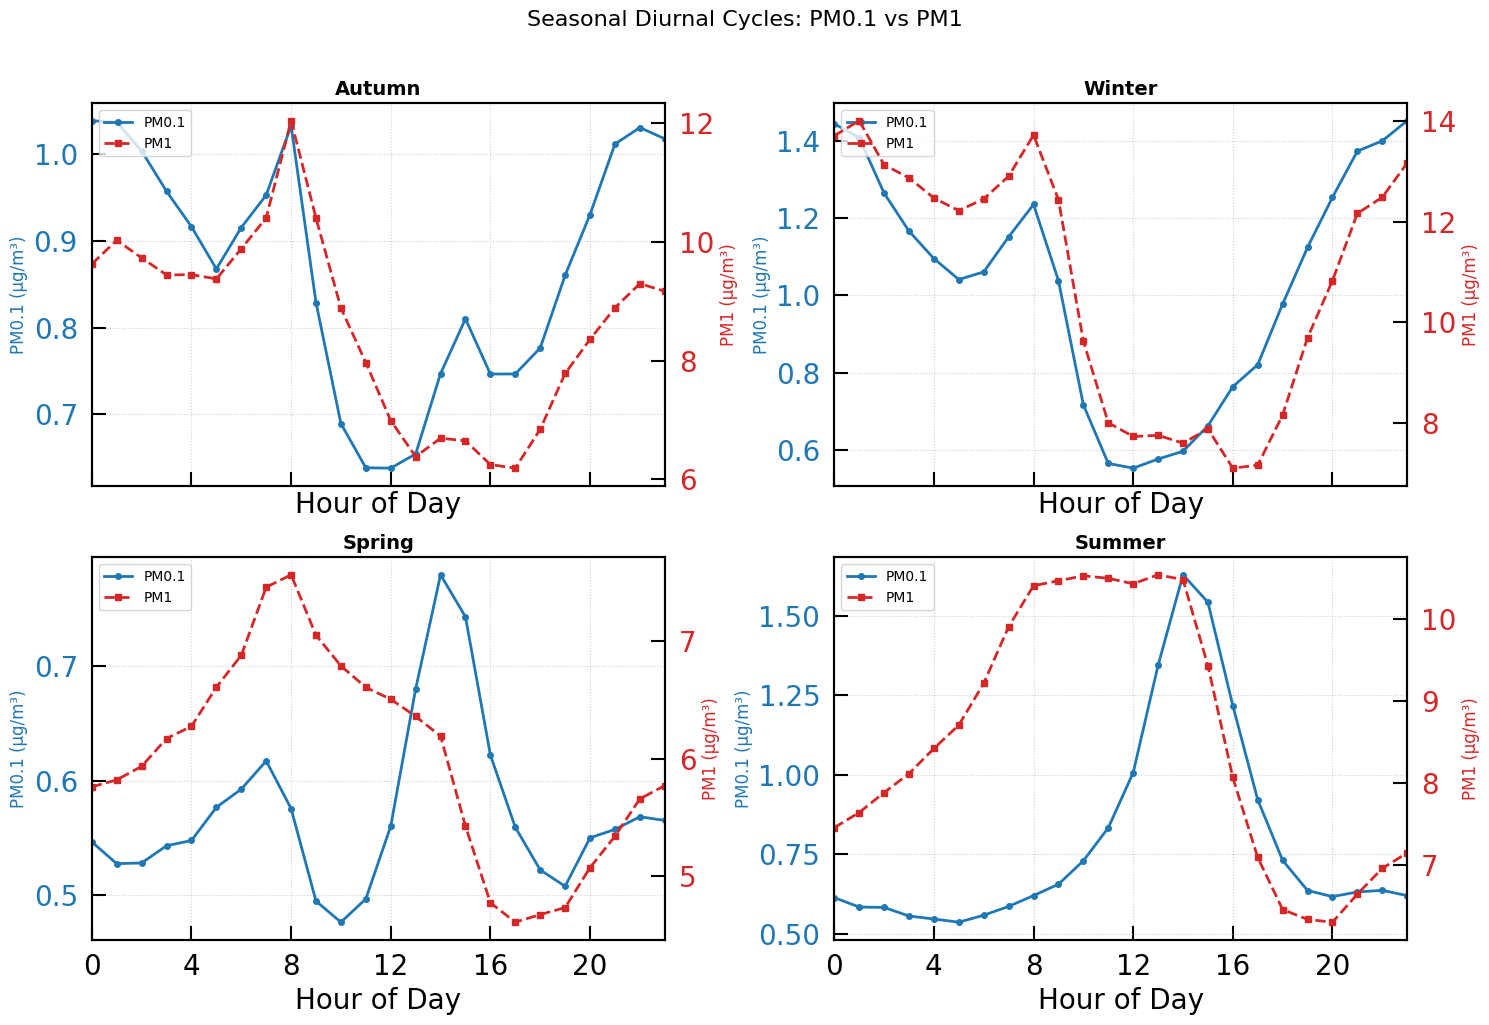

Plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_Diurnal_PM01_PM1_4Panel.png


In [16]:
# Prepare Data
# ---------------------------------------------------------
# Ensure df_hourly exists
df_diurnal = df_hourly.copy()

# Ensure index is datetime
if not isinstance(df_diurnal.index, pd.DatetimeIndex):
    df_diurnal.index = pd.to_datetime(df_diurnal.index)

# Map Months to Seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_diurnal['Season'] = df_diurnal.index.month.map(get_season)
df_diurnal['Hour'] = df_diurnal.index.hour

# Calculate Mean Hourly Values per Season
seasonal_means = df_diurnal.groupby(['Season', 'Hour'])[['PM0.1', 'PM1']].mean().reset_index()

# Create 4-Panel Plot
# ---------------------------------------------------------
seasons = ['Autumn', 'Winter', 'Spring', 'Summer']
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()  # Flatten 2D array of axes for easy looping

for i, season in enumerate(seasons):
    ax1 = axes[i]

    # Filter data for the current season
    data = seasonal_means[seasonal_means['Season'] == season]

    # --- Left Axis: PM0.1 (Blue) ---
    color1 = 'tab:blue'
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('PM0.1 (µg/m³)', color=color1, fontsize=12)
    line1 = ax1.plot(data['Hour'], data['PM0.1'], color=color1, linewidth=2, marker='o', markersize=4, label='PM0.1')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Right Axis: PM1 (Red) ---
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('PM1 (µg/m³)', color=color2, fontsize=12)
    line2 = ax2.plot(data['Hour'], data['PM1'], color=color2, linewidth=2, linestyle='--', marker='s', markersize=4, label='PM1')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Formatting
    ax1.set_title(f'{season}', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(0, 24, 4)) # Ticks every 4 hours
    ax1.set_xlim(0, 23)

    # Optional: Align y-axis starts to 0 if desired
    # ax1.set_ylim(bottom=0)
    # ax2.set_ylim(bottom=0)

    # Combine legends for this subplot
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=True)

plt.suptitle('Seasonal Diurnal Cycles: PM0.1 vs PM1', fontsize=16, y=1.02)
plt.tight_layout()

# Save Plot
output_filename = os.path.join(output_folder, 'Seasonal_Diurnal_PM01_PM1_4Panel.png')
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved to: {output_filename}")

## Seasonal Diurnal Plots AQMD data (Temp, NO2, O3)

C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3234133613.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3234133613.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\3234133613.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


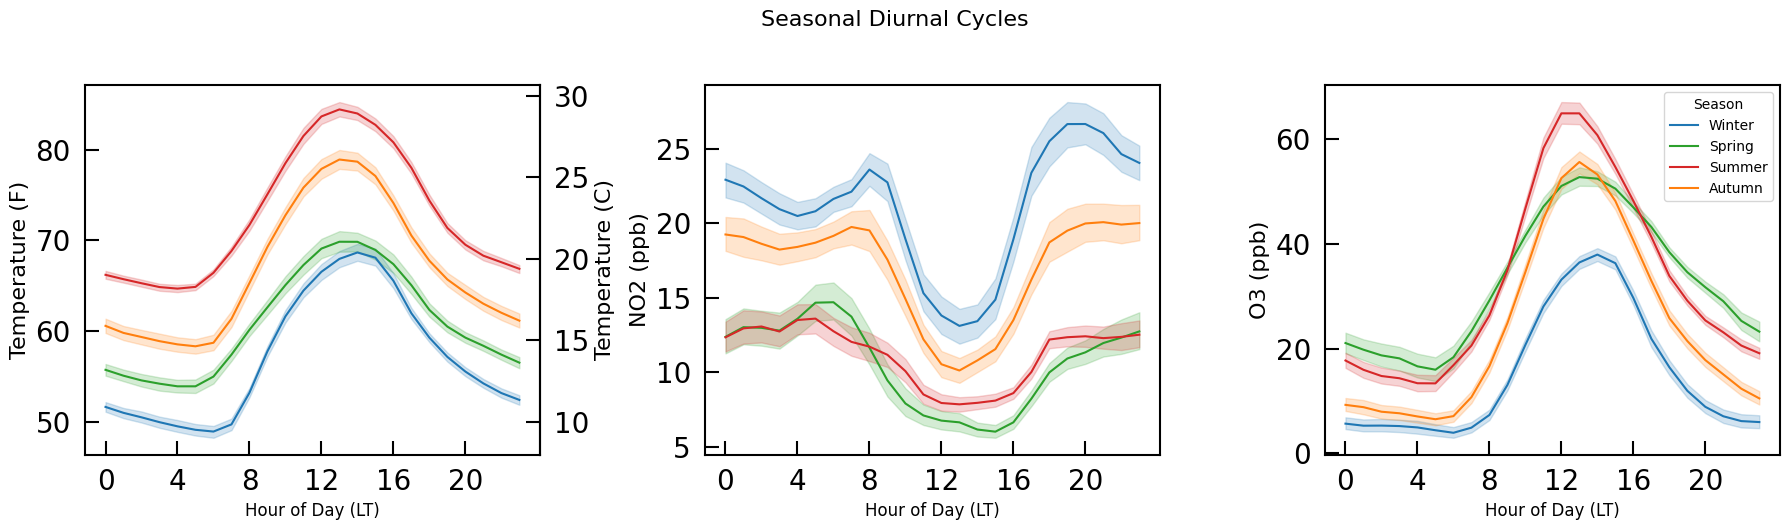

In [24]:
# Prepare Data
# Create a working copy to avoid modifying the original dataframe
df_diurnal = df_met_data.copy()

# Ensure 'Date Time' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df_diurnal['Date Time']):
    df_diurnal['Date Time'] = pd.to_datetime(df_diurnal['Date Time'])

# Extract Hour and Season
df_diurnal['Hour'] = df_diurnal['Date Time'].dt.hour
df_diurnal['Month'] = df_diurnal['Date Time'].dt.month

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df_diurnal['Season'] = df_diurnal['Month'].apply(get_season)

# Setup Plotting
# Parameters to plot: (Column Name, Label)
params_to_plot = [
    ('Temp', 'Temperature (F)'),
    ('NO2',  'NO2 (ppb)'),
    ('O3',   'O3 (ppb)')
]

season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
# Define colors for consistency
season_colors = {'Winter': 'tab:blue', 'Spring': 'tab:green', 'Summer': 'tab:red', 'Autumn': 'tab:orange'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

# Generate Plots
for i, (col, label) in enumerate(params_to_plot):
    ax = axes[i]

    if col in df_diurnal.columns:
        # sns.lineplot automatically calculates the mean and confidence intervals (shaded area)
        sns.lineplot(
            data=df_diurnal,
            x='Hour',
            y=col,
            hue='Season',
            hue_order=season_order,
            palette=season_colors,
            ax=ax,
            ci=95
        )

        ax.set_xlabel('Hour of Day (LT)', fontsize=12)
        ax.set_ylabel(label, fontsize=16)
        ax.set_xticks(range(0, 24, 4)) # Ticks every 4 hours

        # --- ADD CELSIUS AXIS ---
        if col == 'Temp':
            # Define conversion functions
            def f_to_c(x): return (x - 32) * 5 / 9
            def c_to_f(x): return (x * 9 / 5) + 32

            # Create secondary axis on the right
            secax = ax.secondary_yaxis('right', functions=(f_to_c, c_to_f))
            secax.set_ylabel('Temperature (C)', fontsize=16)
        # ----------------------------------

        # Only show legend on the last plot to save space, or adjust as needed
        if i == 2:
            ax.legend(title='Season', loc='best')
        else:
            # Check if legend exists before removing (some versions of seaborn behave differently)
            if ax.get_legend() is not None:
                ax.get_legend().remove()
    else:
        ax.text(0.5, 0.5, f'{col} not found', ha='center', va='center')

plt.suptitle('Seasonal Diurnal Cycles', fontsize=16, y=1.05)
plt.tight_layout()

# Save

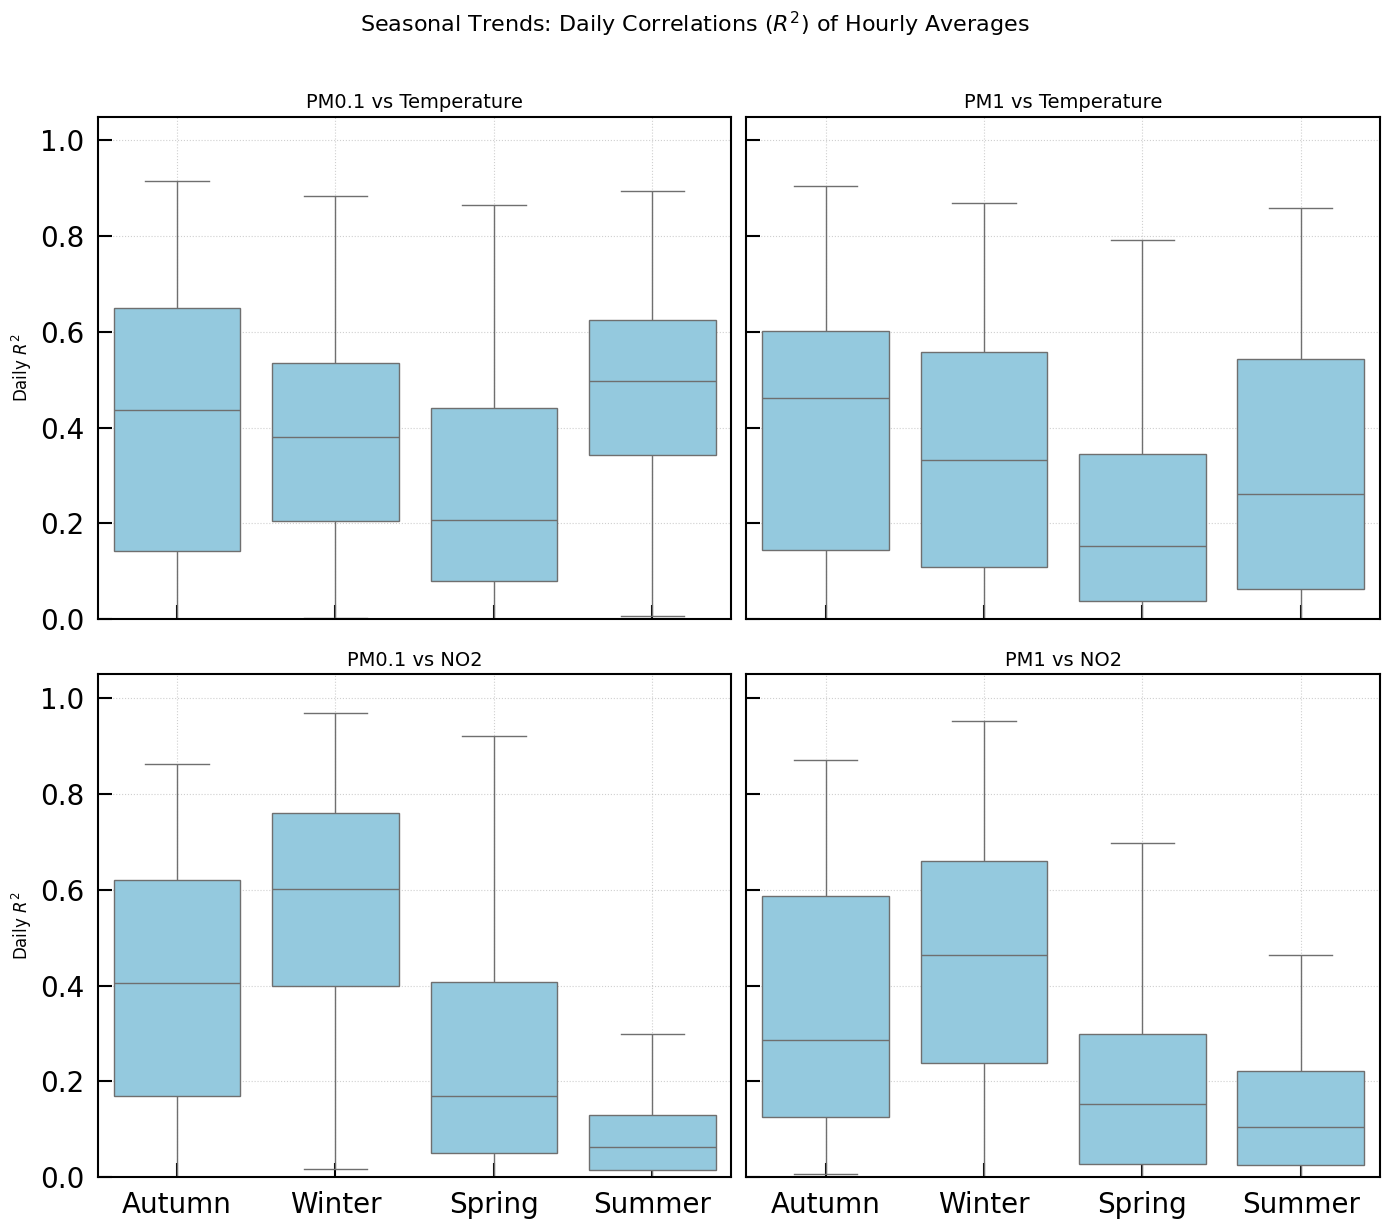

Plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_R2_Boxplots.png


In [68]:
# 1. Merge Particle Data (df_hourly) with Met Data (df_met_data)
# ---------------------------------------------------------
# Check if dataframes exist
if 'df_hourly' not in locals():
    print("Error: 'df_hourly' not found. Please run the 'PM0.1 and PM1 calculations' cell first.")
elif 'df_met_data' not in locals():
    print("Error: 'df_met_data' not found. Please run the meteorological data import cell first.")
else:
    # Prepare df_hourly (Index is usually already datetime, but ensure it)
    df_pm = df_hourly.copy()
    if not isinstance(df_pm.index, pd.DatetimeIndex):
        df_pm.index = pd.to_datetime(df_pm.index)

    # Prepare df_met_data (Set 'Date Time' as index for merging)
    df_met = df_met_data.copy()
    if 'Date Time' in df_met.columns:
        df_met['Date Time'] = pd.to_datetime(df_met['Date Time'])
        df_met = df_met.set_index('Date Time')

    # Merge on index (nearest hour match or exact match)
    # Using inner join to keep only timestamps present in both
    df_merged = pd.merge(df_pm, df_met, left_index=True, right_index=True, how='inner')

    # 2. Define Pairs to Correlate
    # ---------------------------------------------------------
    # Format: (PM_Column, Met_Column, Display_Title)
    # Note: Ensure these column names match your data exactly
    pairs = [
        ('PM0.1', 'Temp', 'PM0.1 vs Temperature'),
        ('PM1',   'Temp', 'PM1 vs Temperature'),
        ('PM0.1', 'NO2',  'PM0.1 vs NO2'),
        ('PM1',   'NO2',  'PM1 vs NO2')
    ]

    # 3. Calculate Daily R2
    # ---------------------------------------------------------
    daily_r2_data = []

    # Group by Date
    for date, day_group in df_merged.groupby(df_merged.index.date):
        # Determine Season for this date
        month = pd.to_datetime(date).month
        if month in [12, 1, 2]: season = 'Winter'
        elif month in [3, 4, 5]: season = 'Spring'
        elif month in [6, 7, 8]: season = 'Summer'
        else: season = 'Autumn'

        # Dictionary to store results for this day
        day_result = {'Season': season, 'Date': date}

        # Calculate R2 for each pair
        for pm_col, met_col, label in pairs:
            # Drop NaNs for this specific pair
            valid_data = day_group[[pm_col, met_col]].dropna()

            # Require at least 12 hours of data to calculate a valid correlation
            if len(valid_data) >= 12:
                corr = valid_data[pm_col].corr(valid_data[met_col])
                day_result[label] = corr ** 2 # R-squared
            else:
                day_result[label] = np.nan

        daily_r2_data.append(day_result)

    df_r2 = pd.DataFrame(daily_r2_data)

    # 4. Generate Plot
    # ---------------------------------------------------------
    season_order = ['Autumn','Winter', 'Spring', 'Summer', ]

    fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (pm_col, met_col, label) in enumerate(pairs):
        ax = axes[i]

        # Plot if data exists
        if label in df_r2.columns:
            sns.boxplot(
                data=df_r2,
                x='Season',
                y=label,
                order=season_order,
                ax=ax,
                color='skyblue',
                showfliers=False # Optional: Hide outliers for cleaner view
            )
            ax.set_title(label, fontsize=14)
            ax.set_ylabel('Daily $R^2$', fontsize=12)
            ax.set_xlabel('')
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.set_ylim(0, 1.05) # R2 is always 0-1
        else:
            ax.text(0.5, 0.5, f'Data for {label} missing', ha='center')

    plt.suptitle('Seasonal Trends: Daily Correlations ($R^2$) of Hourly Averages', fontsize=16, y=1.02)
    plt.tight_layout()

    # Save
    output_filename = os.path.join(output_folder, 'Seasonal_R2_Boxplots.png')
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Plot saved to: {output_filename}")

## Seasonal Weekday Diurnals PM0.1 vs PM1

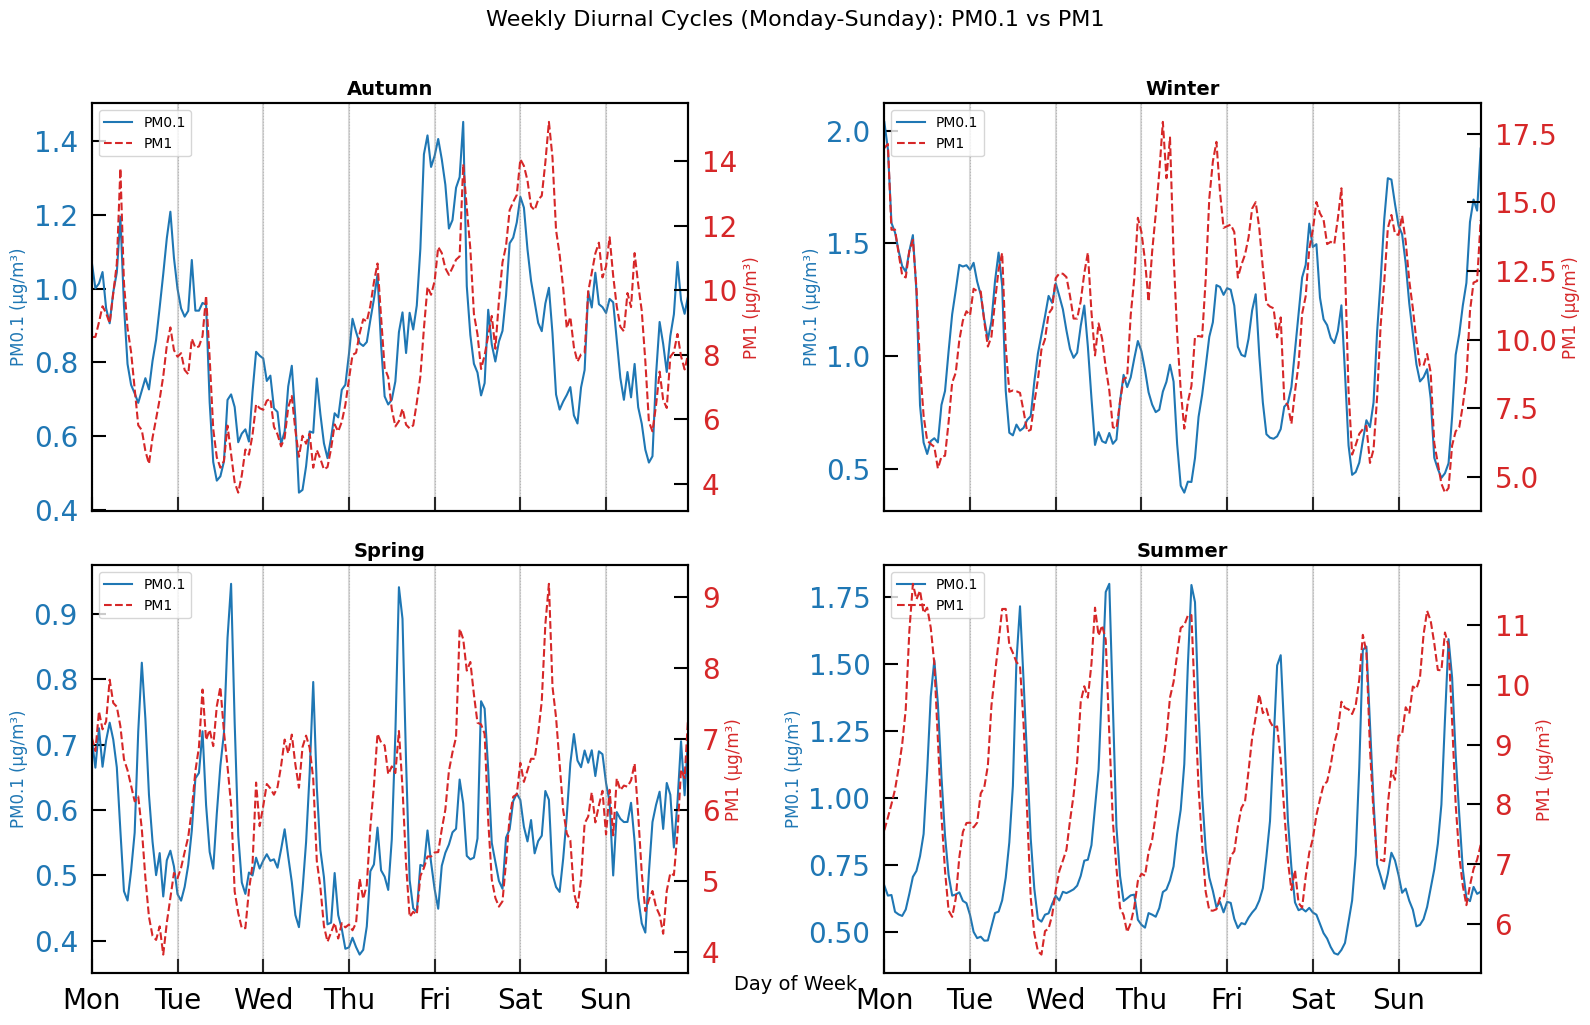

Plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_Weekly_Cycle_PM01_PM1.png


In [20]:
# 1. Prepare Data
# ---------------------------------------------------------
# Ensure df_hourly exists (from Cell 26)
if 'df_hourly' not in locals():
    raise ValueError("variable 'df_hourly' not found. Please run the 'PM0.1 and PM1 calculations' cell first.")

df_weekly = df_hourly.copy()

# Ensure index is datetime
if not isinstance(df_weekly.index, pd.DatetimeIndex):
    df_weekly.index = pd.to_datetime(df_weekly.index)

# Map Months to Seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_weekly['Season'] = df_weekly.index.month.map(get_season)
df_weekly['DayOfWeek'] = df_weekly.index.dayofweek # Mon=0, Sun=6
df_weekly['Hour'] = df_weekly.index.hour

# Group by Season, DayOfWeek, and Hour to get the average weekly cycle
# This creates a composite week for each season
weekly_means = df_weekly.groupby(['Season', 'DayOfWeek', 'Hour'])[['PM0.1', 'PM1']].mean()

# 2. Create 4-Panel Plot
# ---------------------------------------------------------
seasons = ['Autumn', 'Winter', 'Spring', 'Summer']
# Days labels for x-axis
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax1 = axes[i]

    # Extract data for the season
    if season in weekly_means.index.get_level_values('Season'):
        data = weekly_means.loc[season]

        # Create a continuous hourly index for the week (0 to 167)
        # Data is already sorted by DayOfWeek then Hour due to groupby
        # We assume 24 hours for each of the 7 days

        # Flatten the data for plotting
        pm01_vals = data['PM0.1'].values
        pm1_vals = data['PM1'].values

        # Create x-axis (0 to 167 hours)
        x_hours = np.arange(len(pm01_vals))

        # --- Left Axis: PM0.1 (Blue) ---
        color1 = 'tab:blue'
        line1 = ax1.plot(x_hours, pm01_vals, color=color1, linewidth=1.5, label='PM0.1')
        ax1.set_ylabel('PM0.1 (µg/m³)', color=color1, fontsize=12)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.grid(True, linestyle=':', alpha=0.6, axis='x') # Grid lines for days

        # --- Right Axis: PM1 (Red) ---
        ax2 = ax1.twinx()
        color2 = 'tab:red'
        line2 = ax2.plot(x_hours, pm1_vals, color=color2, linewidth=1.5, linestyle='--', label='PM1')
        ax2.set_ylabel('PM1 (µg/m³)', color=color2, fontsize=12)
        ax2.tick_params(axis='y', labelcolor=color2)

        # Formatting
        ax1.set_title(f'{season}', fontsize=14, fontweight='bold')

        # Set x-ticks to be the start of each day (every 24 hours)
        # Center labels slightly if desired, or just put them at 00:00
        ax1.set_xticks(np.arange(0, 168, 24))
        ax1.set_xticklabels(days)
        ax1.set_xlim(0, 167)

        # Add vertical lines to separate days
        for x in range(24, 168, 24):
            ax1.axvline(x=x, color='gray', linestyle='-', alpha=0.3)

        # Legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=10, frameon=True)

# Add shared x-axis label
fig.text(0.5, 0.04, 'Day of Week', ha='center', fontsize=14)

plt.suptitle('Weekly Diurnal Cycles (Monday-Sunday): PM0.1 vs PM1', fontsize=16, y=1.02)
plt.tight_layout()

# Save Plot
output_filename = os.path.join(output_folder, 'Seasonal_Weekly_Cycle_PM01_PM1.png')
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot saved to: {output_filename}")

## Seasonal diurnal coloplot dN/dlogDp

Data Shape: (430679, 115)
Time Index Length: 430679
Calculating seasonal hourly averages...


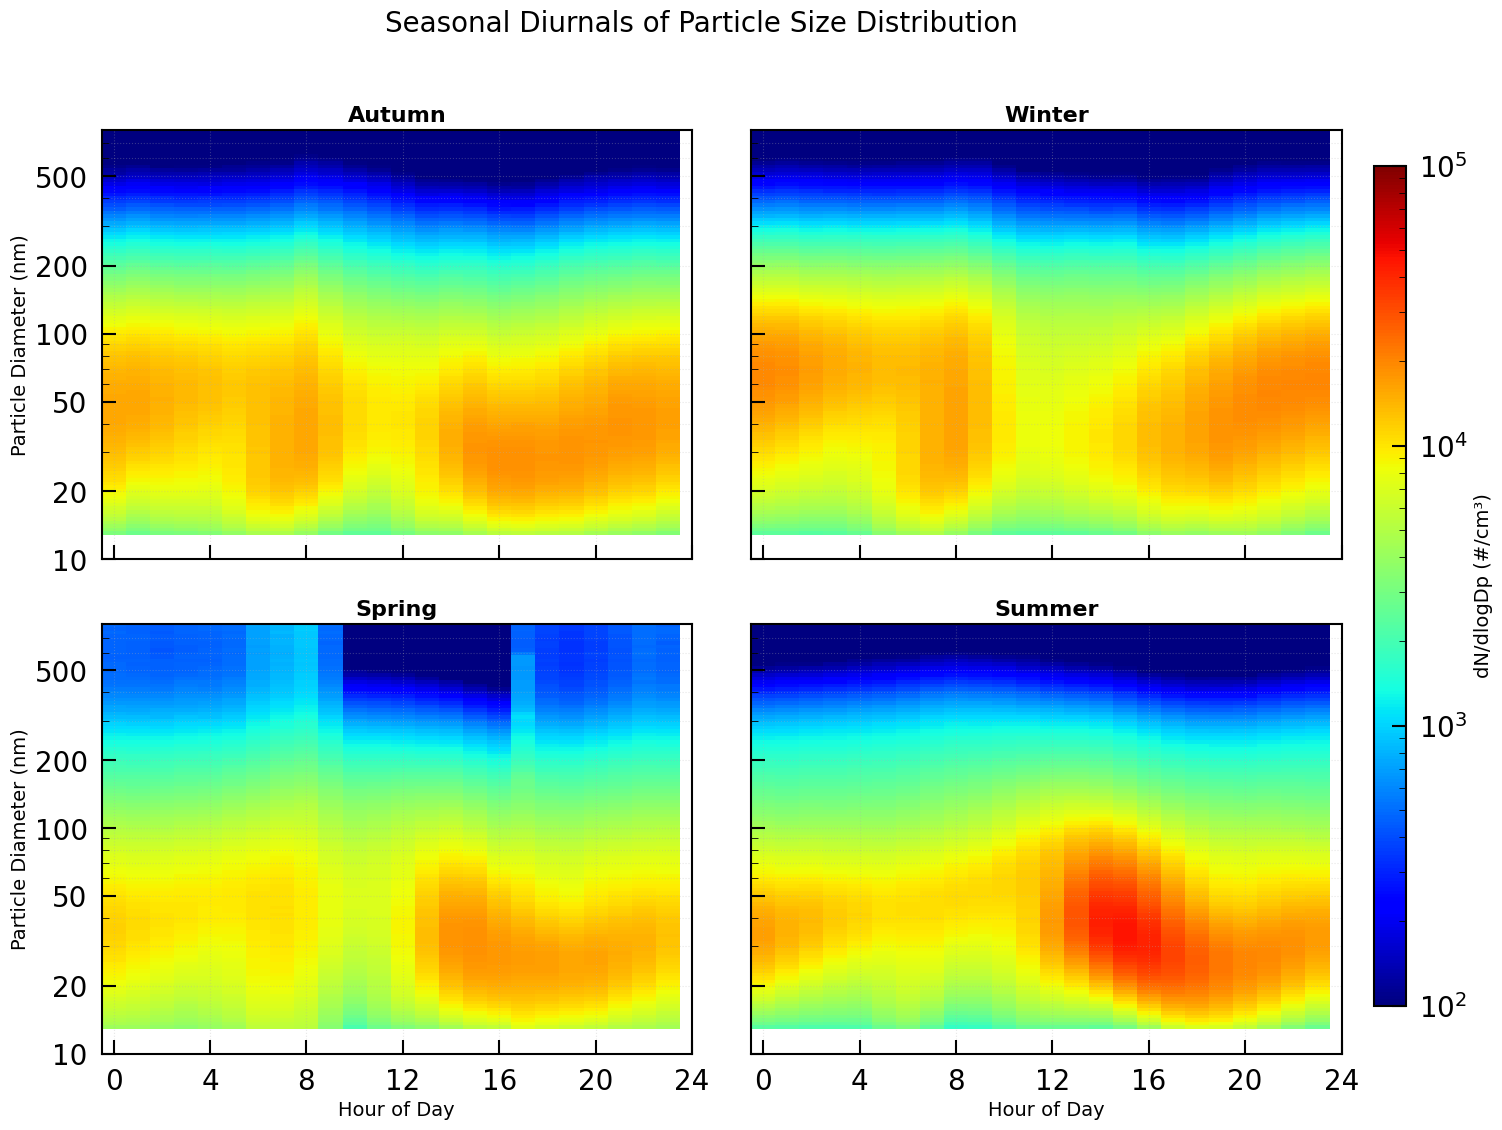

Plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_Diurnals_Colormap.png


In [24]:
# --- USER CONFIGURATION ---
try:
    # 1. Get Particle Data Matrix (High Resolution)
    if 'dNdlogDp_stpp' in locals():
        data_matrix = dNdlogDp_stpp
    else:
        # Fallback if variable names are different
        data_matrix = dNdlogDp

    # 2. Get Diameter Bins
    if 'mid_Dp' in locals():
        diameter_bins = mid_Dp
    else:
        diameter_bins = mid_points

    # 3. Get Time Index (MUST MATCH data_matrix length)
    # We use tsdfp.index (original high-res index) instead of df_hourly.index
    if 'tsdfp' in locals():
        time_index = tsdfp.index
    else:
        # If tsdfp is missing, try to reconstruct from dfp
        time_index = pd.to_datetime(dfp['local_time'])

    # Verification Print
    print(f"Data Shape: {data_matrix.shape}")
    print(f"Time Index Length: {len(time_index)}")

except NameError as e:
    print(f"Variable missing: {e}")
    print("Please ensure you have run the cells that define 'dNdlogDp_stpp' and 'tsdfp'.")

# ---------------------------------------------------------

# 1. Prepare Data
# ---------------------------------------------------------
# Create DataFrame using the HIGH RESOLUTION index
df_dist = pd.DataFrame(data_matrix, index=time_index, columns=diameter_bins)

# Ensure data types are correct (fixes the "log10" error)
df_dist.columns = df_dist.columns.astype(float)
df_dist = df_dist.apply(pd.to_numeric, errors='coerce')

# Handle zeros for Log Plot
df_dist = df_dist.replace(0, np.nan)

# Define Season Function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add grouping columns
# We convert index to datetime just in case it isn't already
df_dist.index = pd.to_datetime(df_dist.index)
df_dist['Season'] = df_dist.index.month.map(get_season)
df_dist['Hour'] = df_dist.index.hour

# 2. Group by Season and Hour
# ---------------------------------------------------------
print("Calculating seasonal hourly averages...")
# This might take a few seconds due to the large dataset size
seasonal_diurnal = df_dist.groupby(['Season', 'Hour']).mean()

# 3. Generate Plots
# ---------------------------------------------------------
season_order = ['Autumn', 'Winter', 'Spring', 'Summer']
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Color Scale Settings (Adjust vmin/vmax if plot is too dark/light)
cmap = plt.cm.jet
vmin = 1e2
vmax = 1e5

for i, season in enumerate(season_order):
    ax = axes[i]

    if season in seasonal_diurnal.index.get_level_values(0):
        data_season = seasonal_diurnal.loc[season]

        # Prepare grids
        X = data_season.index.astype(float)   # Hours (0-23)
        Y = data_season.columns.astype(float) # Diameters
        Z = data_season.values.T              # Concentration

        # Plot
        mesh = ax.pcolormesh(X, Y, Z, cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), shading='auto')

        ax.set_yscale('log')
        ax.set_title(f'{season}', fontsize=16, fontweight='bold')

        # Labels
        if i in [0, 2]:
            ax.set_ylabel('Particle Diameter (nm)', fontsize=14)
        if i in [2, 3]:
            ax.set_xlabel('Hour of Day', fontsize=14)

        # Formatting
        ax.set_xticks(np.arange(0, 25, 4))
        ax.set_yticks([10, 20, 50, 100, 200, 500])
        ax.get_yaxis().set_major_formatter(ScalarFormatter())
        ax.grid(True, which='both', linestyle=':', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', transform=ax.transAxes)

# 4. Colorbar and Save
# ---------------------------------------------------------
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('dN/dlogDp (#/cm³)', fontsize=14)

plt.suptitle('Seasonal Diurnals of Particle Size Distribution', fontsize=20)
plt.subplots_adjust(right=0.9, wspace=0.1, hspace=0.15)

if 'output_folder' not in locals(): output_folder = '.'
plot_filename = os.path.join(output_folder, 'Seasonal_Diurnals_Colormap.png')
plt.savefig(plot_filename, dpi=300)
plt.show()
print(f"Plot saved to: {plot_filename}")

## Seasonal diurnal coloplot dM/dlogDp

Data Shape: (430679, 115)
Calculating seasonal hourly averages for Mass...


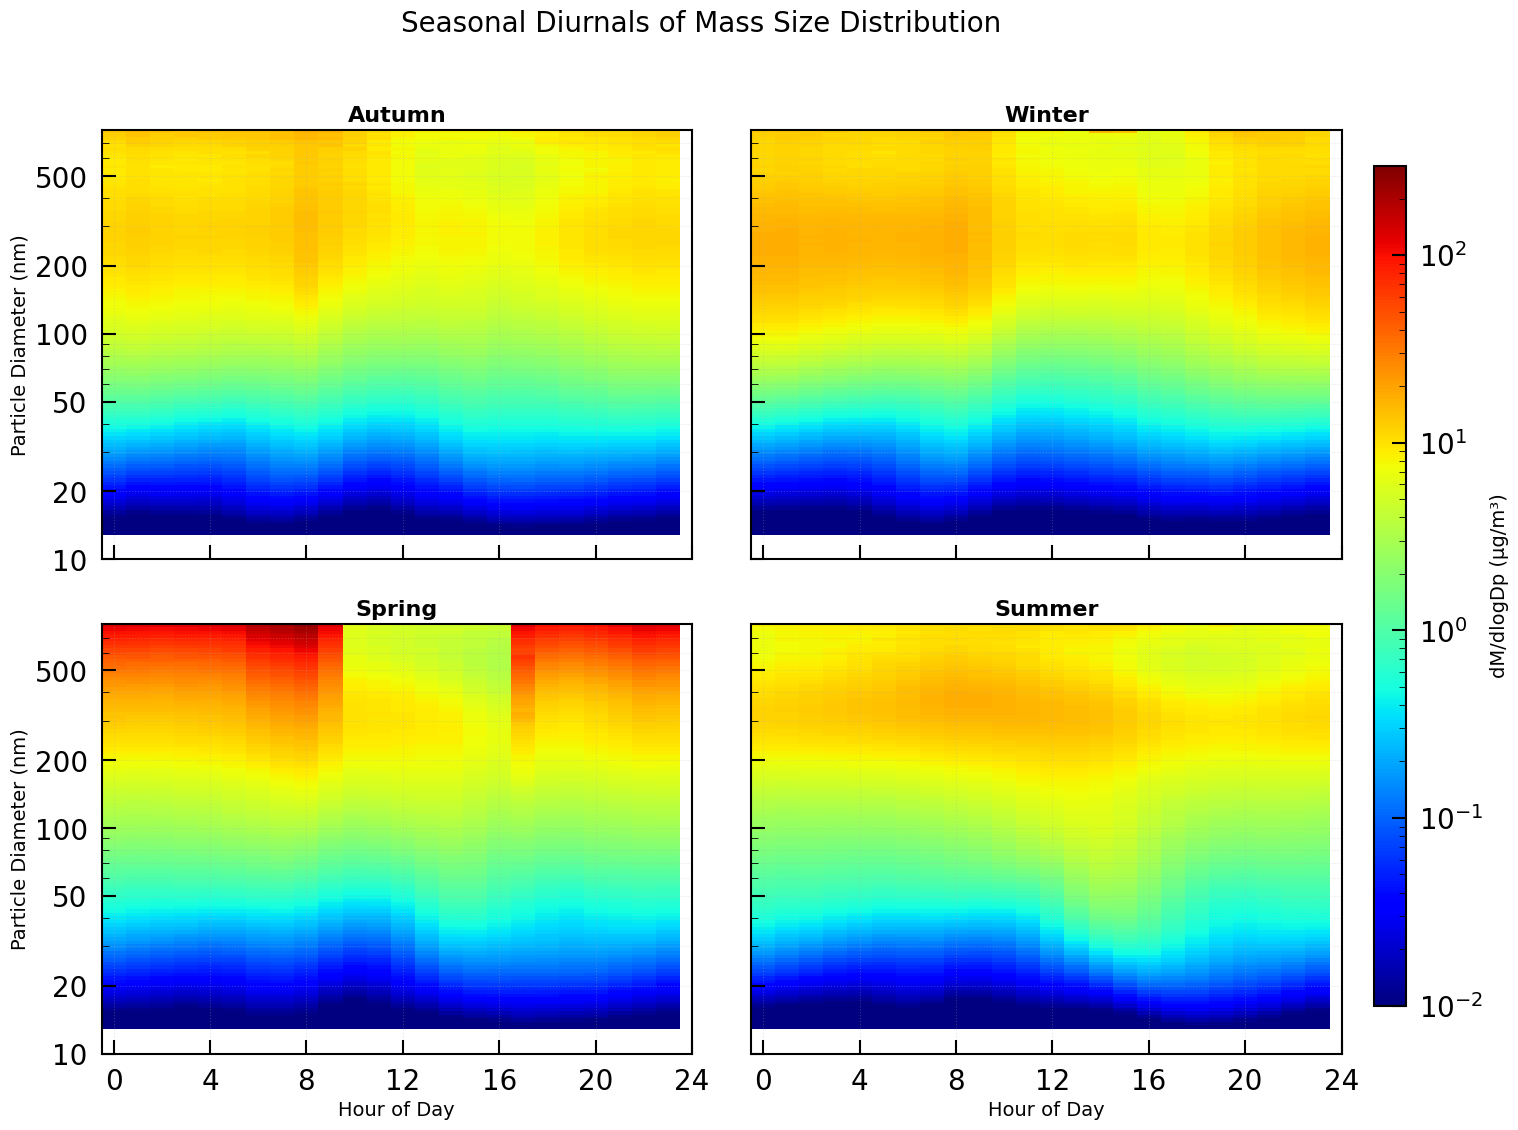

Mass Distribution plot saved to: C:/Users/GeorgiaRg/Documents/ASCENT/SMPS/SMPS_data_analysis_VB/SMPS_Data_Shiny/Output\Seasonal_Diurnals_Colormap_dM.png


In [31]:
# --- USER CONFIGURATION ---
try:
    # 1. Get Mass Data Matrix (dM/dlogDp)
    # Check for the variable calculated in 'PM0.1 and PM1 calculations' cell
    if 'dMdlogDp_stpp' in locals():
        data_matrix = dMdlogDp_stpp
    else:
        # Fallback: Try to calculate it if missing (assuming spherical particles, density=1.2)
        # Note: This is an approximation if the original variable is lost
        print("Variable 'dMdlogDp_stpp' not found. Attempting to calculate from 'dNdlogDp_stpp'...")
        if 'dNdlogDp_stpp' in locals() and 'mid_Dp' in locals():
             # density = 1.2 g/cm3 (standard assumption if unknown)
             # Formula: dM = dN * (pi/6) * Dp^3 * density * unit_conversion
             # We assume mid_Dp is in nm. Conversion factor handles nm->cm and g->ug->m3
             density = 1.0
             data_matrix = dNdlogDp_stpp * (np.pi/6) * (mid_Dp**3) * density * 1e-9
        else:
             raise NameError("dMdlogDp_stpp")

    # 2. Get Diameter Bins
    if 'mid_Dp' in locals():
        diameter_bins = mid_Dp
    else:
        diameter_bins = mid_points

    # 3. Get Time Index
    if 'tsdfp' in locals():
        time_index = tsdfp.index
    else:
        time_index = pd.to_datetime(dfp['local_time'])

    print(f"Data Shape: {data_matrix.shape}")

except NameError as e:
    print(f"⚠️ Variable missing: {e}")
    print("Please run the 'PM0.1 and PM1 calculations' cell first to generate 'dMdlogDp_stpp'.")

# ---------------------------------------------------------

# 1. Prepare Data
# ---------------------------------------------------------
# Create DataFrame
df_dist = pd.DataFrame(data_matrix, index=time_index, columns=diameter_bins)

# Ensure data types are correct
df_dist.columns = df_dist.columns.astype(float)
df_dist = df_dist.apply(pd.to_numeric, errors='coerce')

# Handle zeros for Log Plot (Replace 0 with NaN so they appear white/transparent)
df_dist = df_dist.replace(0, np.nan)

# Define Season Function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add grouping columns
df_dist.index = pd.to_datetime(df_dist.index)
df_dist['Season'] = df_dist.index.month.map(get_season)
df_dist['Hour'] = df_dist.index.hour

# 2. Group by Season and Hour (Calculate Mean)
# ---------------------------------------------------------
print("Calculating seasonal hourly averages for Mass...")
seasonal_diurnal = df_dist.groupby(['Season', 'Hour']).mean()

# 3. Generate Plots
# ---------------------------------------------------------
season_order = ['Autumn', 'Winter', 'Spring', 'Summer']
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Color Scale Settings for MASS
# Mass concentrations are lower than Number concentrations.
# Range typically 0.1 to 50 ug/m3 for these bins.
cmap = plt.cm.jet
vmin = 1e-2  # Lower limit (ug/m3)
vmax = 3e2   # Upper limit (ug/m3)

for i, season in enumerate(season_order):
    ax = axes[i]

    if season in seasonal_diurnal.index.get_level_values(0):
        data_season = seasonal_diurnal.loc[season]

        # Prepare grids
        X = data_season.index.astype(float)   # Hours (0-23)
        Y = data_season.columns.astype(float) # Diameters
        Z = data_season.values.T              # Mass Concentration

        # Plot
        mesh = ax.pcolormesh(X, Y, Z, cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), shading='auto')

        ax.set_yscale('log')
        ax.set_title(f'{season}', fontsize=16, fontweight='bold')

        # Labels
        if i in [0, 2]:
            ax.set_ylabel('Particle Diameter (nm)', fontsize=14)
        if i in [2, 3]:
            ax.set_xlabel('Hour of Day', fontsize=14)

        # Formatting
        ax.set_xticks(np.arange(0, 25, 4))
        ax.set_yticks([10, 20, 50, 100, 200, 500])
        ax.get_yaxis().set_major_formatter(ScalarFormatter())
        ax.grid(True, which='both', linestyle=':', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', transform=ax.transAxes)

# 4. Colorbar and Save
# ---------------------------------------------------------
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('dM/dlogDp (µg/m³)', fontsize=14)

plt.suptitle('Seasonal Diurnals of Mass Size Distribution', fontsize=20)
plt.subplots_adjust(right=0.9, wspace=0.1, hspace=0.15)

if 'output_folder' not in locals(): output_folder = '.'
plot_filename = os.path.join(output_folder, 'Seasonal_Diurnals_Colormap_dM.png')
plt.savefig(plot_filename, dpi=300)
plt.show()
print(f"Mass Distribution plot saved to: {plot_filename}")

<>:49: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:49: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
C:\Users\GeorgiaRg\AppData\Local\Temp\ipykernel_14820\2186551115.py:49: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  ax.set_legend(title=f"{pollutant_col} ($ \mu g/m^3 $)", loc='best', bbox_to_anchor=(1.1, 1))


Generating Pollution Rose for PM0.1...


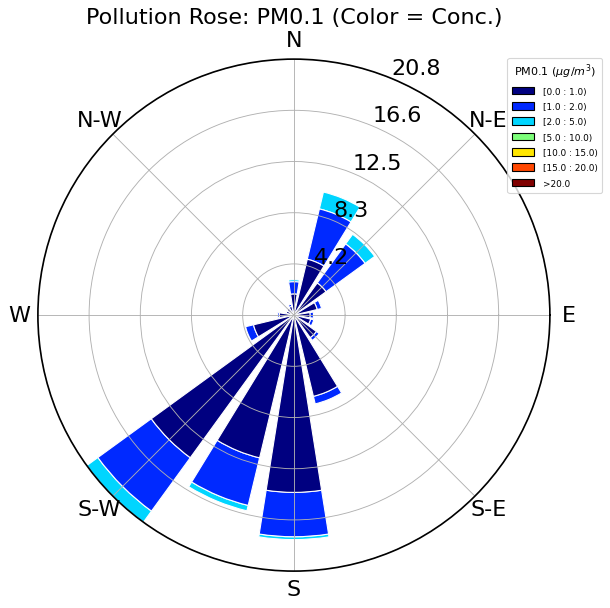

Generating Pollution Rose for PM1...


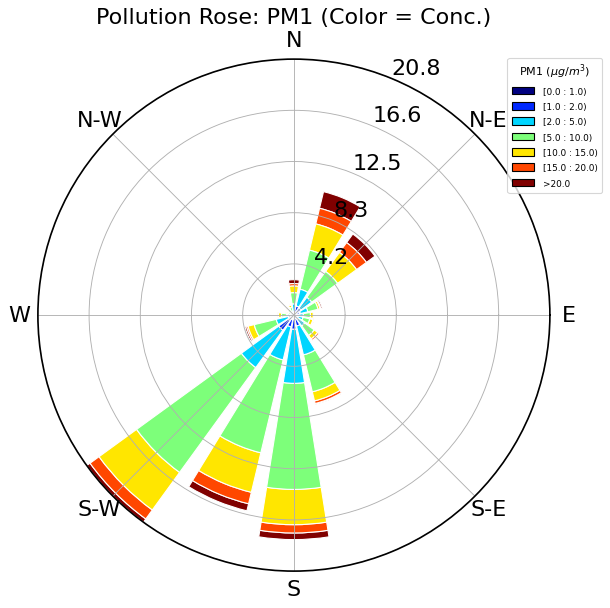

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# --- 1. PREPARE & MERGE DATA ---

# Ensure df_hourly index is datetime (This contains PM0.1, PM1)
if not isinstance(df_hourly.index, pd.DatetimeIndex):
    df_hourly.index = pd.to_datetime(df_hourly.index)

# Ensure df_met_data 'Date Time' is datetime and set as index (This contains WS, WD)
# df_met_data comes from the earlier cells in your notebook
if 'Date Time' in df_met_data.columns:
    df_met_data = df_met_data.set_index('Date Time')
df_met_data.index = pd.to_datetime(df_met_data.index)

# Merge the two dataframes on their timestamps
# 'inner' join ensures we only plot times where we have BOTH PM and Wind data
df_rose = pd.merge(df_hourly, df_met_data, left_index=True, right_index=True, how='inner')

# --- 2. DEFINE PLOTTING FUNCTION ---

def plot_pollution_rose(data, pollutant_col, ws_col='WS', wd_col='WD'):
    """
    Plots a pollution rose where:
    - Direction (WD) = Wind Direction
    - Length of bar = Frequency of wind from that direction
    - Color = Concentration of the Pollutant (PM0.1 or PM1)
    """
    # Remove missing values for the specific columns we are using
    data_clean = data[[pollutant_col, ws_col, wd_col]].dropna()

    # Initialize the Windrose Axis
    ax = WindroseAxes.from_ax()

    # Plot using bar style
    # 'var' determines the values used for coloring (The Pollutant)
    # 'direction' determines the angle (Wind Direction)
    ax.bar(data_clean[wd_col], data_clean[pollutant_col],
           normed=True,       # Normalize to show percentage frequencies
           opening=0.8,       # Width of the bars (0.8 is standard)
           edgecolor='white',
           cmap=cm.jet,       # Colormap (Jet goes Blue->Red)
           bins=[0, 1, 2, 5, 10, 15, 20]) # Adjust these bins based on your PM concentration levels!

    # Add title and legend
    ax.set_title(f"Pollution Rose: {pollutant_col} (Color = Conc.)")
    ax.set_legend(title=f"{pollutant_col} ($ \mu g/m^3 $)", loc='best', bbox_to_anchor=(1.1, 1))

    plt.show()

# --- 3. GENERATE THE MAPS ---

print("Pollution Rose for PM0.1")
plot_pollution_rose(df_rose, 'PM0.1')

print("Pollution Rose for PM1")
plot_pollution_rose(df_rose, 'PM1')

# Add Black Carbon Data

In [18]:
dNdlogDp_stpp.shape

(430679, 115)

In [19]:
# Add N_stp array to the corresponding DataFrame
dfp['N_stp'] = N_stp


ValueError: Length of values (430679) does not match length of index (431271)

## Concatenate all csv files in a folder for Aethelometer data

In [ ]:
# concatenate
df_list = (pd.read_csv(file) for file in aeth_csv_files)

# Concatenate all DataFrames
dfb   = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
dfb['time'] = pd.to_datetime(dfb['time'], format='%Y-%m-%d %H:%M:%S')

## Convert to local time

In [ ]:
def convert_to_local(df):

    dfb_local = df.copy()

    # Local timezone (replace with your local timezone)
    source_timezone = pytz.timezone('UTC')
    local_timezone = pytz.timezone('America/Los_Angeles')

    # Use the tz_convert function to convert the datetime column
    dfb_local['time'] = df['time'].dt.tz_localize(source_timezone).dt.tz_convert(local_timezone)
    dfb_local['time'] = pd.to_datetime(dfb_local["time"].dt.strftime('%Y-%m-%d %H:%M:%S'))

    dfb_local.rename(columns={'time':'local_time_bc'}, inplace=True)
    return dfb_local

## Call the local time conversion function, convert_to_local, to get the new df, dfb_local, which has the aethelometer data now in local time

In [ ]:
dfb_local = convert_to_local(dfb)

Calculate the rolling 30 minute average of the vehicular black carbon concentration (EBC_6 in aethelometer data)

Make a merged dataframe which contains both SMPS and Aethelometer data across consistent timestamps

Add a column to the original SMPS dataframe which represents the rolling 30 minute average black carbon, here titled 30_min_avg (from the column EBC_6 in aethelometer data) 

In [ ]:


# --- Step 1: Ensure datetime and set index for rolling calculation ---
dfb_local['local_time_bc'] = pd.to_datetime(dfb_local['local_time_bc'])
dfb_local = dfb_local.sort_values('local_time_bc').set_index('local_time_bc')

# --- Step 2: Calculate rolling 30-min average for EBC_6 ---
dfb_local['30_min_avg'] = dfb_local['EBC_6'].rolling('30T').mean()

# --- Step 3: Reset index so local_time_bc is a column again ---
dfb_local = dfb_local.reset_index()

# --- Step 4: Ensure dfp datetime is correct ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])

# --- Step 5: Merge using merge_asof ---
merged_df = pd.merge_asof(
    dfp.sort_values('local_time'),
    dfb_local[['local_time_bc', '30_min_avg']].sort_values('local_time_bc'),
    left_on='local_time',
    right_on='local_time_bc',
    direction='nearest',
    suffixes=('', '_bc')  # avoid naming conflicts
)


# --- Step 6: Add the rolling average column to dfp ---
if '30_min_avg' in merged_df.columns:
    dfp['30_min_avg'] = merged_df['30_min_avg']
else:
    raise KeyError("⚠ '30_min_avg' not found in merged_df. Check dfb_local generation.")

print(dfp[['local_time', '30_min_avg']].head())

In [ ]:
dfp # can check to ensure 30_min_avg column was added to dfp here

# Plotting Section 

## Time series colormap plot for every day in the dataset (x=time, y=diameter (nm), z=dNdlogDp)

Here, I use a warped colormap (a cubic function instead of linear) which emphasizes the variation in the high concentrations

In [ ]:
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap = warp_colormap(base_cmap, high_end_bias)

# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
XX, YY = np.meshgrid(X, Y)
Z = dNdlogDp_stpp.copy().T
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')



os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    fig, ax1 = plt.subplots(figsize=(16, 5))
    pcm = ax1.pcolormesh(x_day, YY[:, :z_day.shape[1]], z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=1e5)) # jt

    cbar = fig.colorbar(pcm, ax=ax1)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')    

    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)

    # Custom y-tick locations and labels
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))

    ax1.set_ylabel('Dp (nm)')
    ax1.set_xlabel('local_time')
    ax1.tick_params(axis='both', which='major')

    ax1.xaxis.set_major_formatter(DateFormatter('%H'))
    ax1.set_xlim(x_day[0], x_day[-1])
    
    ax1.set_title(f'test pico SMPS - {date}')    

    plt.tight_layout()

    # Save only once here
    filename = os.path.join(output_folder, f'pico_time_series_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory, no need to call plt.show()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

# Plot with 4 time series in the top plots and their respective N_stps in the lower plots

In [ ]:
# Move to other code, keep this one too 
# --- Warped colormap setup ---
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3


# Color list
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa', 
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

custom_cmap = warp_colormap(base_cmap, high_end_bias)




def get_day_data(df, Z_all, mid_Dp, date_str):
    date = pd.to_datetime(date_str).date()
    df = df.copy()
    df['local_time'] = pd.to_datetime(df['local_time'])
    df['date'] = df['local_time'].dt.date

    mask = df['date'] == date

    if mask.sum() == 0:
        raise ValueError(f"No data found for date {date_str} in the dataframe.")

    df_day = df[mask]
    X = mdates.date2num(df_day['local_time'])

    z_day = Z_all[:, mask.values]  # Use .values to index numpy array

    return X, mid_Dp, z_day, df_day
# Define which days and sites to show
plot_info = [
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-04', 'Pico Rivera - Example 1', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-05', 'Pico Rivera - Example 2', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-06', 'Pico Rivera - Example 3', 1e5),
    (dfp, dNdlogDp_stpp.T, mid_Dp, '2024-05-07', 'Pico Rivera - Example 4', 1e5),
]



fig = plt.figure(figsize=(18, 12))
gs = GridSpec(4, 2, height_ratios=[3, 2, 3, 2], hspace=0.75, wspace=0.3)

for i, (df, Z, mid_D, date, name, vmax) in enumerate(plot_info):
    Z_masked = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))
    X, Y, z_day, df_day = get_day_data(df, Z_masked, mid_D, date)

    col_row = 0 if i < 2 else 2
    col_col = i % 2

    start = pd.to_datetime(date + ' 00:00')
    end = pd.to_datetime(date + ' 23:59')

    # meshgrid for pcolormesh
    XX, YY = np.meshgrid(X, Y)

    # --- Colormap plot ---
    ax1 = fig.add_subplot(gs[col_row, col_col])
    pcm = ax1.pcolormesh(XX, YY, z_day, shading='auto',
                         cmap=custom_cmap, norm=LogNorm(vmin=10, vmax=vmax))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)
    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'{name} - {date}')

    def log_tick_formatter(val, pos=None):
        exponent = int(np.log10(val))
        return f'$10^{{{exponent}}}$'

    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    cbar.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

    # --- Mean magnitude plot ---
    ax2 = fig.add_subplot(gs[col_row + 1, col_col], sharex=ax1)
    ax2.plot(df_day['local_time'], df_day['N_stp'], color='black', lw=2)
    ax2.set_ylabel('Total N (# cm$^{-3}$)')

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlim(start, end)

    ax2.set_xlabel('local_time')


    # Align bottom plot width to top plot width
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])


plt.tight_layout(rect=[0, 0, 0.9, 1])
filename = os.path.join(output_folder, f'pico_4_panel_event_plot_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()


## Plot with time series with black carbon (30_min_avg) in bottom plot (1 figure per day)

In [ ]:
# --- Data setup ---
dfp['local_time'] = pd.to_datetime(dfp['local_time'])
dfp['date'] = dfp['local_time'].dt.date

# Ensure dfp and SMPS are aligned
assert dfp.shape[0] == dNdlogDp_stpp.shape[0], "Mismatch between dfp and SMPS data!"

# Meshgrid setup (once, reused)
Time = pd.to_datetime(dfp['local_time'])
X = mdates.date2num(Time)
Y = mid_Dp.copy()
Z = dNdlogDp_stpp.copy().T  # Shape: (sizes, timestamps)
Z_all = np.ma.masked_invalid(np.asarray(Z, dtype=np.float64))

# --- Daily plot loop ---
plot_counter = 0
grouped = dfp.groupby('date')

os.makedirs(output_folder, exist_ok=True)  # Ensure folder exists

for date, group in grouped:
    # Mask for this date
    day_mask = dfp['date'] == date
    x_day = X[day_mask]
    z_day = Z_all[:, day_mask]

    if z_day.shape[1] == 0:
        continue

    black_carbon = dfp.loc[day_mask, '30_min_avg'].values

    start = pd.to_datetime(str(date) + ' 00:00')
    end = pd.to_datetime(str(date) + ' 23:59')

    # --- Create figure with two panels ---
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # --- Top: SMPS heatmap ---
    ax1 = fig.add_subplot(gs[0])
    XX, YY = np.meshgrid(x_day, Y)
    pcm = ax1.pcolormesh(XX, YY[:, :z_day.shape[1]], z_day,
                         shading='auto', cmap=custom_cmap,
                         norm=LogNorm(vmin=10, vmax=1e5))
    ax1.set_yscale('log')
    ax1.set_ylim(13, 800)
    ax1.set_xlim(start, end)

    yticks = [13, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500, 600, 700, 800]
    ax1.set_yticks(yticks)
    label_ticks = {13: '13', 100: '100', 800: '800'}
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: label_ticks.get(y, '')))
    ax1.set_ylabel('Dp (nm)')
    ax1.set_title(f'SMPS + Black Carbon - {date}')
    ax1.tick_params(axis='x', labelbottom=False)

    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax1, pad=0.01, aspect=30)
    cbar.set_label('$\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')

    # --- Bottom: Black Carbon ---
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(dfp.loc[day_mask, 'local_time'], black_carbon, color='red', lw=2)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_ylabel('Black Carbon\n(µg/m³)')
    ax2.set_xlim(start, end)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax2.set_xlabel('local_time')

    # --- Align subplot widths ---
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    ax2.set_position([pos1.x0, pos2.y0, pos1.width, pos2.height])

    # Save figure
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    filename = os.path.join(output_folder, f'time_series_plot_with_bc_{date}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    plot_counter += 1

print(f'Number of days plotted: {plot_counter}')

# Average N_stp over whole dataset (Weekend Versus Weekday)

In [17]:
# Move to other code, keep this here
lower_p = dfp['N_stp'].quantile(0.01)
upper_p = dfp['N_stp'].quantile(0.99)
dfp_no_outliers = dfp[(dfp['N_stp'] >= lower_p) & (dfp['N_stp'] <= upper_p)].copy()

# Make sure hour and dayofweek columns exist in the filtered dataframes
for df in [dfp_no_outliers, dfp_no_outliers]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6
    
# Create weekday and weekend masks
weekday_mask_p = dfp_no_outliers['dayofweek'].isin(range(5))  # 0-4
weekend_mask_p = dfp_no_outliers['dayofweek'].isin([5,6])     # 5-6

# Group by hour and take mean N_stp for weekdays and weekends
weekday_p = dfp_no_outliers[weekday_mask_p].groupby('hour')['N_stp'].mean()
weekend_p = dfp_no_outliers[weekend_mask_p].groupby('hour')['N_stp'].mean()

#################
# After filtering and adding 'hour' and 'dayofweek' columns (dfp_no_outliers and dfp_no_outliers)...

# Print samples for Pico Rivera (dfp_no_outliers)
print("Pico Rivera Sample Weekday Dates (with weekday name):")
for d in dfp_no_outliers[weekday_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

print("\nPico Rivera Sample Weekend Dates (with weekday name):")
for d in dfp_no_outliers[weekend_mask_p]['local_time'].dt.date.drop_duplicates().sort_values().head(10):
    print(f"{d} ({pd.to_datetime(d).strftime('%A')})")

#################

# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(weekday_p.index, weekday_p, label='Pico Rivera - Weekday', color='tab:blue', linewidth=2)
plt.plot(weekend_p.index, weekend_p, label='Pico Rivera - Weekend', color='tab:blue', linestyle='--', linewidth=2)

plt.xlabel('Hour of Day')
plt.ylabel('Mean N_stp (#/cm³)')

plt.title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

plt.legend()

plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))  # Show all hours 0 through 23

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

KeyError: 'N_stp'

## Average N_stp and BC (30_min_avg) over whole dataset (Weekend Versus Weekday)

In [ ]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp and BC ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek ---
for df in [df_nstp, df_bc]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek  # Monday=0, Sunday=6

# --- 4️⃣ Weekday/weekend masks ---
weekday_mask_n = df_nstp['dayofweek'].isin(range(5))
weekend_mask_n = df_nstp['dayofweek'].isin([5,6])

weekday_mask_bc = df_bc['dayofweek'].isin(range(5))
weekend_mask_bc = df_bc['dayofweek'].isin([5,6])

# --- 5️⃣ Compute hourly means ---
weekday_nstp = df_nstp[weekday_mask_n].groupby('hour')['N_stp'].mean()
weekend_nstp = df_nstp[weekend_mask_n].groupby('hour')['N_stp'].mean()

weekday_bc = df_bc[weekday_mask_bc].groupby('hour')['30_min_avg'].mean()
weekend_bc = df_bc[weekend_mask_bc].groupby('hour')['30_min_avg'].mean()

# --- 6️⃣ Plot both variables in stacked subplots ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# N_stp Plot
axes[0].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue', linewidth=2)
axes[0].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--', linewidth=2)
axes[0].set_ylabel('Mean N_stp (#/cm³)')

axes[0].set_title('Weekday vs. Weekend Diurnal N_stp — Pico Rivera (Outliers Removed)')

axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# BC Plot
axes[1].plot(weekday_bc.index, weekday_bc, label='Weekday', color='tab:red', linewidth=2)
axes[1].plot(weekend_bc.index, weekend_bc, label='Weekend', color='tab:red', linestyle='--', linewidth=2)
axes[1].set_ylabel('Mean BC (µg/m³)')
axes[1].set_xlabel('Hour of Day')
axes[1].set_title('Weekday vs. Weekend Diurnal BC — Pico Rivera (Outliers Removed)')

axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.xlim(0, 23)
plt.xticks(range(0, 24))
plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_N_stp_BC_.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()



# Event Frequency

- These are estimated frequencies, you will need to define your own how you wish

- Feel free to change the frequencies here and even the variable name from pico_freq, just be sure to change the varable name from pico_freq to the name you picked in this line: bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')  


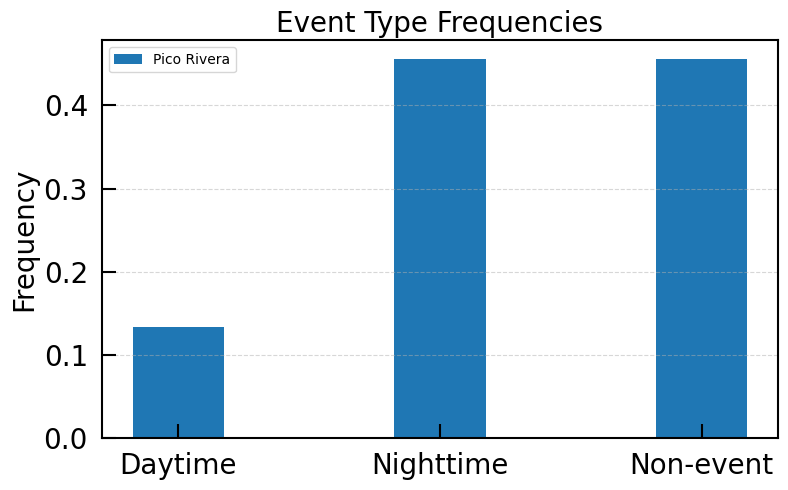

In [21]:
# Example data
event_types = ['Daytime', 'Nighttime', 'Non-event'] # these can have different names
pico_freq = [0.13333333333333333, 0.45555555555555555, 0.45555555555555555] # change the frequencies
x = np.arange(len(event_types))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x, pico_freq, width, label='Pico Rivera', color='#1f77b4')

# Labels and styling
ax.set_ylabel('Frequency')
ax.set_title('Event Type Frequencies')
ax.set_xticks(x)
ax.set_xticklabels(event_types)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5, axis='y')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_event_frequencies.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Average Particle size distributions

Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

Divide the dataset into day and night, and then calculate the average size distributions during those time periods for the whole dataset

In [ ]:
df_copyp = tsdfp.copy()

In [ ]:

df_copyp.columns[concentration_columns]

## Start with the taking the average dNdlogDp across all times for Pico Rivera and Rubidoux

In [ ]:
# Change columns here if needed
selected_colsp = df_copyp.columns[concentration_columns]
bin_diametersp = np.array(selected_colsp).astype(float)
dNdlogDp_stpp_numeric = np.array(dNdlogDp_stpp, dtype='float')
# Mask out bins with all NaNs
valid_binsp = ~np.all(np.isnan(dNdlogDp_stpp_numeric), axis=0)

# Compute average across time for valid bins
mean_spectrum_p = np.nanmean(dNdlogDp_stpp_numeric[:, valid_binsp], axis=0)
bin_diameters_validp = bin_diametersp[valid_binsp]


## Calculate the average size distributions during the day (9am to 8pm) and night (9pm to 8am) 

In [ ]:
df_copyp = df_copyp.reset_index()

In [ ]:
df_copyp

In [ ]:
# Convert timestamp column to datetime, if not already
df_copyp['local_time'] = pd.to_datetime(df_copyp['local_time'])

# Extract hour
df_copyp['hour'] = df_copyp['local_time'].dt.hour

In [ ]:
# Daytime: 09:00–20:00
day_maskp = df_copyp['hour'].between(9, 20)

# Nighttime: 21:00–23:59 and 00:00–08:59
night_maskp = ~day_maskp  # everything else

In [ ]:
# Convert dNdlogDp_stpp to numeric if not already done
dNdlogDp_stpp_numeric = pd.DataFrame(dNdlogDp_stpp).apply(pd.to_numeric, errors='coerce').values

# Apply masks to get subsets
dNdlogDp_dayp = dNdlogDp_stpp_numeric[day_maskp.values]
dNdlogDp_nightp = dNdlogDp_stpp_numeric[night_maskp.values]

In [ ]:
mean_dayp = np.nanmean(dNdlogDp_dayp, axis=0)
mean_nightp = np.nanmean(dNdlogDp_nightp, axis=0)

## Plot the total and day/night averages on same figure

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 cols, share y-axis

# First subplot: Average size distribution comparison
axes[0].plot(bin_diameters_validp, mean_spectrum_p, marker='o', label='Pico Rivera', color='blue')


axes[0].set_xscale('log')
axes[0].set_xlabel('Particle Diameter (nm)')
axes[0].set_ylabel('Mean dN/dlogDp (#/cm³)')
axes[0].set_title('Average Particle Size Distribution')

axes[0].tick_params(axis='both', which='major')

axes[0].grid(True, which='both', linestyle='--', alpha=0.5)
axes[0].set_xticks([10, 100])

axes[0].legend()


# Second subplot: Day vs Night for both sites
axes[1].plot(bin_diameters_validp, mean_dayp, label='Pico Day (9am–8pm)', color='blue', linewidth=3)
axes[1].plot(bin_diameters_validp, mean_nightp, label='Pico Night (9pm–8am)', color='blue', linestyle='--', linewidth=3)

axes[1].set_xscale('log')
axes[1].set_xlabel('Particle Diameter (nm)')
axes[1].set_title('Day vs Night Particle Size Distribution')
axes[1].tick_params(axis='both', which='major')

axes[1].grid(True, which='both', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_day_vs_night_dNdlogDp.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## Average Total Number Concentration per Weekday

In [ ]:
dfp['local_time'] = pd.to_datetime(dfp['local_time'], errors='coerce')
dfp = dfp.set_index('local_time')
dfp = dfp.dropna(subset=['N_stp'])
dfp['weekday'] = dfp.index.day_name()

# Remove outliers using z-score
dfp_copy = dfp.copy()
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]

# Define ordered weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a list of (weekday, DataFrame) tuples in order
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# Plot setup
fig, axs = plt.subplots(1, 7, figsize=(18, 5), sharey=True)
axs = axs.flatten()

for i, (day, group) in enumerate(weekday_groups):
    avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
    axs[i].plot(avg_diurnal.index, avg_diurnal.values)
    axs[i].set_title(day)
    axs[i].set_xlabel('Hour of Day')

    if i == 0:
        axs[i].set_ylabel('Avg N_stp (# cm$^{-3}$)')

# Final plot formatting
plt.suptitle('Average Total Number Concentration per Weekday (Pico Rivera)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
filename = os.path.join(output_folder, f'pico_avg_N_stp_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

## N_stp averaged and BC over days of the week for the whole dataset

In [ ]:
# --- 1️⃣ Copy dfp to avoid SettingWithCopy warnings ---

# --- 2️⃣ Remove outliers using z-score ---
dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['N_stp'].astype(float), nan_policy='omit')) < 3]
if '30_min_avg' in dfp_copy.columns:
    dfp_copy = dfp_copy[np.abs(zscore(dfp_copy['30_min_avg'].astype(float), nan_policy='omit')) < 3]

# --- 3️⃣ Ensure datetime index and add weekday ---
if not isinstance(dfp_copy.index, pd.DatetimeIndex):
    dfp_copy.index = pd.to_datetime(dfp_copy.index, errors='coerce')

dfp_copy['weekday'] = dfp_copy.index.day_name()

# --- 4️⃣ Define weekday order ---
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# --- 5️⃣ Create weekday groups ---
weekday_groups = [(day, dfp_copy[dfp_copy['weekday'] == day]) for day in ordered_days]

# --- 6️⃣ Plot setup: 2 rows, shared y per row ---
fig, axs = plt.subplots(2, 7, figsize=(20, 8), sharex=True, sharey='row')
axs = axs.reshape(2, 7)

hours = range(24)  # x-axis for hours

# --- Row 1: N_stp ---
for i, (day, group) in enumerate(weekday_groups):
    if not group.empty:
        avg_diurnal = group.groupby(group.index.hour)['N_stp'].mean()
        axs[0, i].plot(avg_diurnal.index, avg_diurnal.values, color='tab:blue', linewidth=2)
    axs[0, i].set_title(day)
    axs[0, i].set_xlim(0, 23)
    axs[0, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[0, i].set_ylabel('Avg N_stp (# cm$^{-3}$)')
    axs[0, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for N_stp
axs[0, 0].set_ylim(0, dfp_copy['N_stp'].max() * 1.1)

# --- Row 2: 30_min_avg ---
for i, (day, group) in enumerate(weekday_groups):
    if '30_min_avg' in group.columns and not group.empty:
        avg_diurnal_bc = group.groupby(group.index.hour)['30_min_avg'].mean()
        axs[1, i].plot(avg_diurnal_bc.index, avg_diurnal_bc.values, color='tab:red', linewidth=2)
    axs[1, i].set_xlim(0, 23)
    axs[1, i].set_xticks(range(0, 24, 4))
    if i == 0:
        axs[1, i].set_ylabel('Avg BC (µg/m³)')
    axs[1, i].grid(True, linestyle='--', alpha=0.3)

# Optional: set a reasonable y-limit for BC
axs[1, 0].set_ylim(0, dfp_copy['30_min_avg'].max() * 1.1)

# --- 7️⃣ Final formatting ---
for ax in axs[1, :]:
    ax.set_xlabel('Hour of Day')

fig.suptitle('Average Diurnal Profiles per Weekday (Pico Rivera, Outliers Removed via Z-score)')

plt.tight_layout(rect=[0, 0, 1, 0.95])

filename = os.path.join(output_folder, 'pico_avg_N_stp_BC_per_weekday.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Average dNdlogDp per Hour

In [ ]:
# Convert to float array
dNdlogDp_stpp = np.asarray(dNdlogDp_stpp, dtype=float)

# Step 1: Calculate z-scores across columns (bins)
z_scores = np.abs(zscore(dNdlogDp_stpp, axis=0, nan_policy='omit'))

# Step 2: Keep only rows where all bins are < 3 std dev
outlier_mask = (z_scores < 3).all(axis=1)

# Step 3: Filter both the data and the datetime index
dNdlogDp_filtered = dNdlogDp_stpp[outlier_mask]
dfp_filtered = tsdfp[outlier_mask]

# Step 4: Add hour column and group by hour
dfp_filtered.index = pd.to_datetime(dfp_filtered.index)
dfp_filtered['hour'] = dfp_filtered.index.hour

df_number = pd.DataFrame(dNdlogDp_filtered, index=dfp_filtered['hour'])
hourly_avgp = df_number.groupby(df_number.index).mean()  # shape: (24, n_bins)

# Step 5: Plot with turbo colormap
cmap = cm.get_cmap('turbo')

plt.figure(figsize=(12, 6))
for hr in range(24):
    color = cmap(hr / 23)  # normalize hour → [0, 1]
    plt.plot(bin_diametersp, hourly_avgp.iloc[hr], label=f'{hr:02d}', color=color)

plt.xscale('log')
plt.xlabel('Particle Diameter (nm)')
plt.ylabel('Mean $\\dfrac{dN}{dlogDp}$ (# cm$^{-3}$)')
plt.title('Pico Rivera Hourly Average Number Size Distributions (Outliers Removed)')
plt.legend(ncol=3, title='Hour')

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_avg_dNdlogDp_per_hour.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


# Reset Index

In [ ]:
dfp = dfp.reset_index()

# Growth Rate Calculation

Preliminary, calculates GR in nm/hr using the geometric mean diameter (Geo. Mean (nm)):

[Geo. Mean (nm) at Time 2 - Geo. Mean (nm) at Time 1] / [Time 2 - Time 1]

In [ ]:
def add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)', max_gap_min=3):
    """
    Adds a growth rate column (nm/hr) to the DataFrame by computing
    the slope between each point and the next valid point (gap ≤ max_gap_min).
    """
    df = dfp.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Initialize growth rate column
    growth_rates = np.full(len(df), np.nan)
    
    for i in range(len(df) - 1):
        dt = (df[time_col].iloc[i+1] - df[time_col].iloc[i]).total_seconds() / 60  # in minutes
        if dt <= max_gap_min and dt > 0:
            dD = df[diam_col].iloc[i+1] - df[diam_col].iloc[i]  # diameter change (nm)
            growth_rates[i] = dD / (dt / 60)  # convert to nm/hr
    
    df['growth_rate_nm_hr'] = growth_rates
    return df

# --- Example usage ---
dfp = add_growth_rate_column(dfp, time_col='local_time', diam_col='Geo. Mean (nm)')

## Average N_stp, BC, and GR in June, July

In [ ]:
# --- 1️⃣ Function to remove outliers ---
def remove_outliers(df, column):
    lower = df[column].quantile(0.01)
    upper = df[column].quantile(0.99)
    return df[(df[column] >= lower) & (df[column] <= upper)].copy()

# --- 2️⃣ Remove outliers for N_stp, BC, and GR ---
df_nstp = remove_outliers(dfp, 'N_stp')
df_bc = remove_outliers(dfp, '30_min_avg')
df_gr = remove_outliers(dfp, 'growth_rate_nm_hr')

# --- 3️⃣ Convert time column to datetime and extract hour/dayofweek/month ---
for df in [df_nstp, df_bc, df_gr]:
    df['local_time'] = pd.to_datetime(df['local_time'], errors='coerce')
    df['hour'] = df['local_time'].dt.hour
    df['dayofweek'] = df['local_time'].dt.dayofweek
    df['month'] = df['local_time'].dt.month

# --- 4️⃣ Define months of interest ---
months = {6: 'June', 7: 'July'}

# --- 5️⃣ Create figure with 3 rows (N_stp, BC, GR) × 2 columns (months) ---
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

for idx, (month_num, month_name) in enumerate(months.items()):
    # --- Weekday/weekend masks ---
    weekday_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin(range(5))
    weekend_n = (df_nstp['month'] == month_num) & df_nstp['dayofweek'].isin([5,6])
    
    weekday_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin(range(5))
    weekend_bc = (df_bc['month'] == month_num) & df_bc['dayofweek'].isin([5,6])
    
    weekday_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin(range(5))
    weekend_gr = (df_gr['month'] == month_num) & df_gr['dayofweek'].isin([5,6])
    
    # --- Hourly means ---
    weekday_nstp = df_nstp[weekday_n].groupby('hour')['N_stp'].mean()
    weekend_nstp = df_nstp[weekend_n].groupby('hour')['N_stp'].mean()
    
    weekday_bc_data = df_bc[weekday_bc].groupby('hour')['30_min_avg'].mean()
    weekend_bc_data = df_bc[weekend_bc].groupby('hour')['30_min_avg'].mean()
    
    weekday_gr_data = df_gr[weekday_gr].groupby('hour')['growth_rate_nm_hr'].mean()
    weekend_gr_data = df_gr[weekend_gr].groupby('hour')['growth_rate_nm_hr'].mean()

    # --- Plot N_stp ---
    axes[0, idx].plot(weekday_nstp.index, weekday_nstp, label='Weekday', color='tab:blue')
    axes[0, idx].plot(weekend_nstp.index, weekend_nstp, label='Weekend', color='tab:blue', linestyle='--')
    axes[0, idx].set_title(f'{month_name} – N_stp')
    axes[0, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[0, idx].set_ylabel('Mean N_stp (#/cm³)')
        axes[0, idx].legend()

    # --- Plot BC ---
    axes[1, idx].plot(weekday_bc_data.index, weekday_bc_data, label='Weekday', color='tab:red')
    axes[1, idx].plot(weekend_bc_data.index, weekend_bc_data, label='Weekend', color='tab:red', linestyle='--')
    axes[1, idx].set_title(f'{month_name} – BC')
    axes[1, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[1, idx].set_ylabel('Mean BC (µg/m³)')
        axes[1, idx].legend()

    # --- Plot Growth Rate ---
    axes[2, idx].plot(weekday_gr_data.index, weekday_gr_data, label='Weekday', color='tab:green')
    axes[2, idx].plot(weekend_gr_data.index, weekend_gr_data, label='Weekend', color='tab:green', linestyle='--')
    axes[2, idx].set_title(f'{month_name} – Growth Rate')
    axes[2, idx].grid(True, linestyle='--', alpha=0.3)
    if idx == 0:
        axes[2, idx].set_ylabel('Growth Rate (nm/hr)')
        axes[2, idx].legend()

# --- Shared X-axis settings ---
for ax in axes[2]:
    ax.set_xlabel('Hour of Day')
for ax_row in axes:
    for ax in ax_row:
        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
filename = os.path.join(output_folder, f'pico_weekend_vs_weekday_monthly.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
dfp

## Colormap time series plot of dNdlogDp_stp over the whole time period with the new, warped colormap

In [ ]:
dNdlogDp_stpp.shape

In [ ]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Same Plot but for longer time periods:

In [ ]:
# ---- Custom colormap warp ----
def warp_colormap(cmap, warp_func, N=256):
    orig = np.linspace(0, 1, N)
    warped = warp_func(orig)
    warped = np.clip(warped, 0, 1)
    warped_colors = cmap(warped)
    return LinearSegmentedColormap.from_list("warped_cmap", warped_colors)

def high_end_bias(x):
    return x**3

# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']
base_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Warp it
custom_cmap = warp_colormap(base_cmap, high_end_bias)

Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time.to_numpy())

Y = mid_Dp  # shape (115,)

Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape should be (115, len(X))

if Z.shape[1] != len(X):
    raise ValueError(f"Mismatch: Z has {Z.shape[1]} columns, X has {len(X)} timestamps")

XX, YY = np.meshgrid(X, Y)
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())


# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')


# X-axis ticks every 60 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')


plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_warped_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Colormap time series plot of dNdlogDp_stp over the whole time period with the old colormap

In [ ]:
# Base colors (your custom palette)
colors = ['#313695', '#4575b4', '#74add1', '#a6cfe2', '#fddcaa',
          '#fdae61', '#f46d43', '#d73027', '#a50026']

custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# ---- Prepare data for pcolormesh ----
Time = pd.to_datetime(dfp['local_time'], format='%Y-%m-%d %H:%M:%S')
X = mdates.date2num(Time)           # numeric time for pcolormesh
Y = mid_Dp.copy()                   # particle diameters
XX, YY = np.meshgrid(X, Y)          # 2D mesh
Z = np.asarray(dNdlogDp_stpp.T, dtype=np.float64)  # shape must be (len(Y), len(X))
masked_Z = np.ma.masked_invalid(Z)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(18, 6))

vmin = 10
vmax = 1e5

pcm = ax1.pcolormesh(
    XX, YY, masked_Z,
    shading='auto',
    cmap=custom_cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax)
)

# Colorbar with log ticks
def log_tick_formatter(val, pos=None):
    exponent = int(np.log10(val))
    return f'$10^{{{exponent}}}$'

cbar = fig.colorbar(pcm, ax=ax1, label='$\\dfrac{dN}{dlogDp}$ (stp cts cm$^{-3}$)')
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))

cbar.set_label(cbar.ax.get_ylabel())

# Axis formatting
ax1.set_yscale('log')
ax1.set_ylim(10, max(Y))
ax1.set_ylabel('Dp (nm)')
ax1.tick_params(axis='both', which='major')

# X-axis ticks every 15 days
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Title
ax1.set_title('Pico Rivera Size Distribution Time Series')

plt.tight_layout()
filename = os.path.join(output_folder, 'pico_size_dist_time_series_old_colormap.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
